# Predicting Sales for I3 Company

by Mingkai Liu,      March-2020

<a id='Contents'></a> 
### [Contents]

#### 1. [Problem definition and summary of proposed solution](#Problem_definition_and_summary_of_proposed_solution)
  
#### 2. [Exploratory Data Analysis](#Exploratory_Data_Analysis)

#### 3. [Feature Engineering](#Feature_Engineering)

#### 4. [Model Construction and Evaluation](#Model_Construction_and_Evaluation)

#### 5. [More sections](#More_Sections)




 <a id='Problem_definition_and_summary_of_proposed_solution'></a>
 ##  1. [Problem_definition_and_summary_of_proposed_solution](#Contents)

This notebook is for the final project in the online course [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science). 

In this project, we are given the sales information of company I3 over the past two years. There are over 5000 items for over 40 shops that needs to be predicted. 

The goal is to predict total sales for every product item and shop in the next month.

Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)

In [169]:
items = pd.read_csv('../input/items.csv')
shops = pd.read_csv('../input/shops.csv')
cats = pd.read_csv('../input/item_categories.csv')
train = pd.read_csv('../input/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('../input/test.csv').set_index('ID')

<a id='Exploratory_Data_Analysis'></a> 
## 2. [Exploratory Data Analysis](#Contents)

In [4]:
#%history -g

In [5]:
# @hidden_cell


# DATA_FOLDER = '../input/competitive-data-science-predict-future-sales/'

In [171]:
# # see how many unique items are there
train.head()
print('There are {} unique item_id in "train"'.format(train['item_id'].nunique()))

items.head()
print('There are {} unique item_id in "items"'.format(items['item_id'].nunique()))

cats.head()
print('There are {} unique item_categories in "cats"'.format(cats['item_category_id'].nunique()))

shops.head()
print('There are {} unique "shops"'.format(shops.shop_id.nunique()))

test.head()
print('There are {} items in "test"'.format(test[['shop_id','item_id']].nunique()))

There are 21807 unique item_id in "train"
There are 22170 unique item_id in "items"
There are 84 unique item_categories in "cats"
There are 60 unique "shops"
There are shop_id      42
item_id    5100
dtype: int64 items in "test"


In [143]:
# # let's see how many unique shop_id and item_id are found in the combined table
# tran_item.item_id.nunique()

# tran_item.shop_id.nunique()
train.head()
items.head()

item_id  item_category_id
0        0                40
1        1                76
2        2                40
3        3                40
4        4                40

In [144]:
# # find the unique shop/item pairs.
# # drop the duplicate rows based on ['shop_id','item_id','item_category_id']
item_shop = train[['shop_id','item_id']].drop_duplicates(['shop_id','item_id'])
item_shop = pd.merge(item_shop, items, on='item_id', how='left')
item_shop.shape
item_shop.head()

shop_id  item_id  item_category_id
0       59    22154                37
1       25     2552                58
2       25     2554                58
3       25     2555                56
4       25     2564                59

Text(0,0.5,'shop_id')

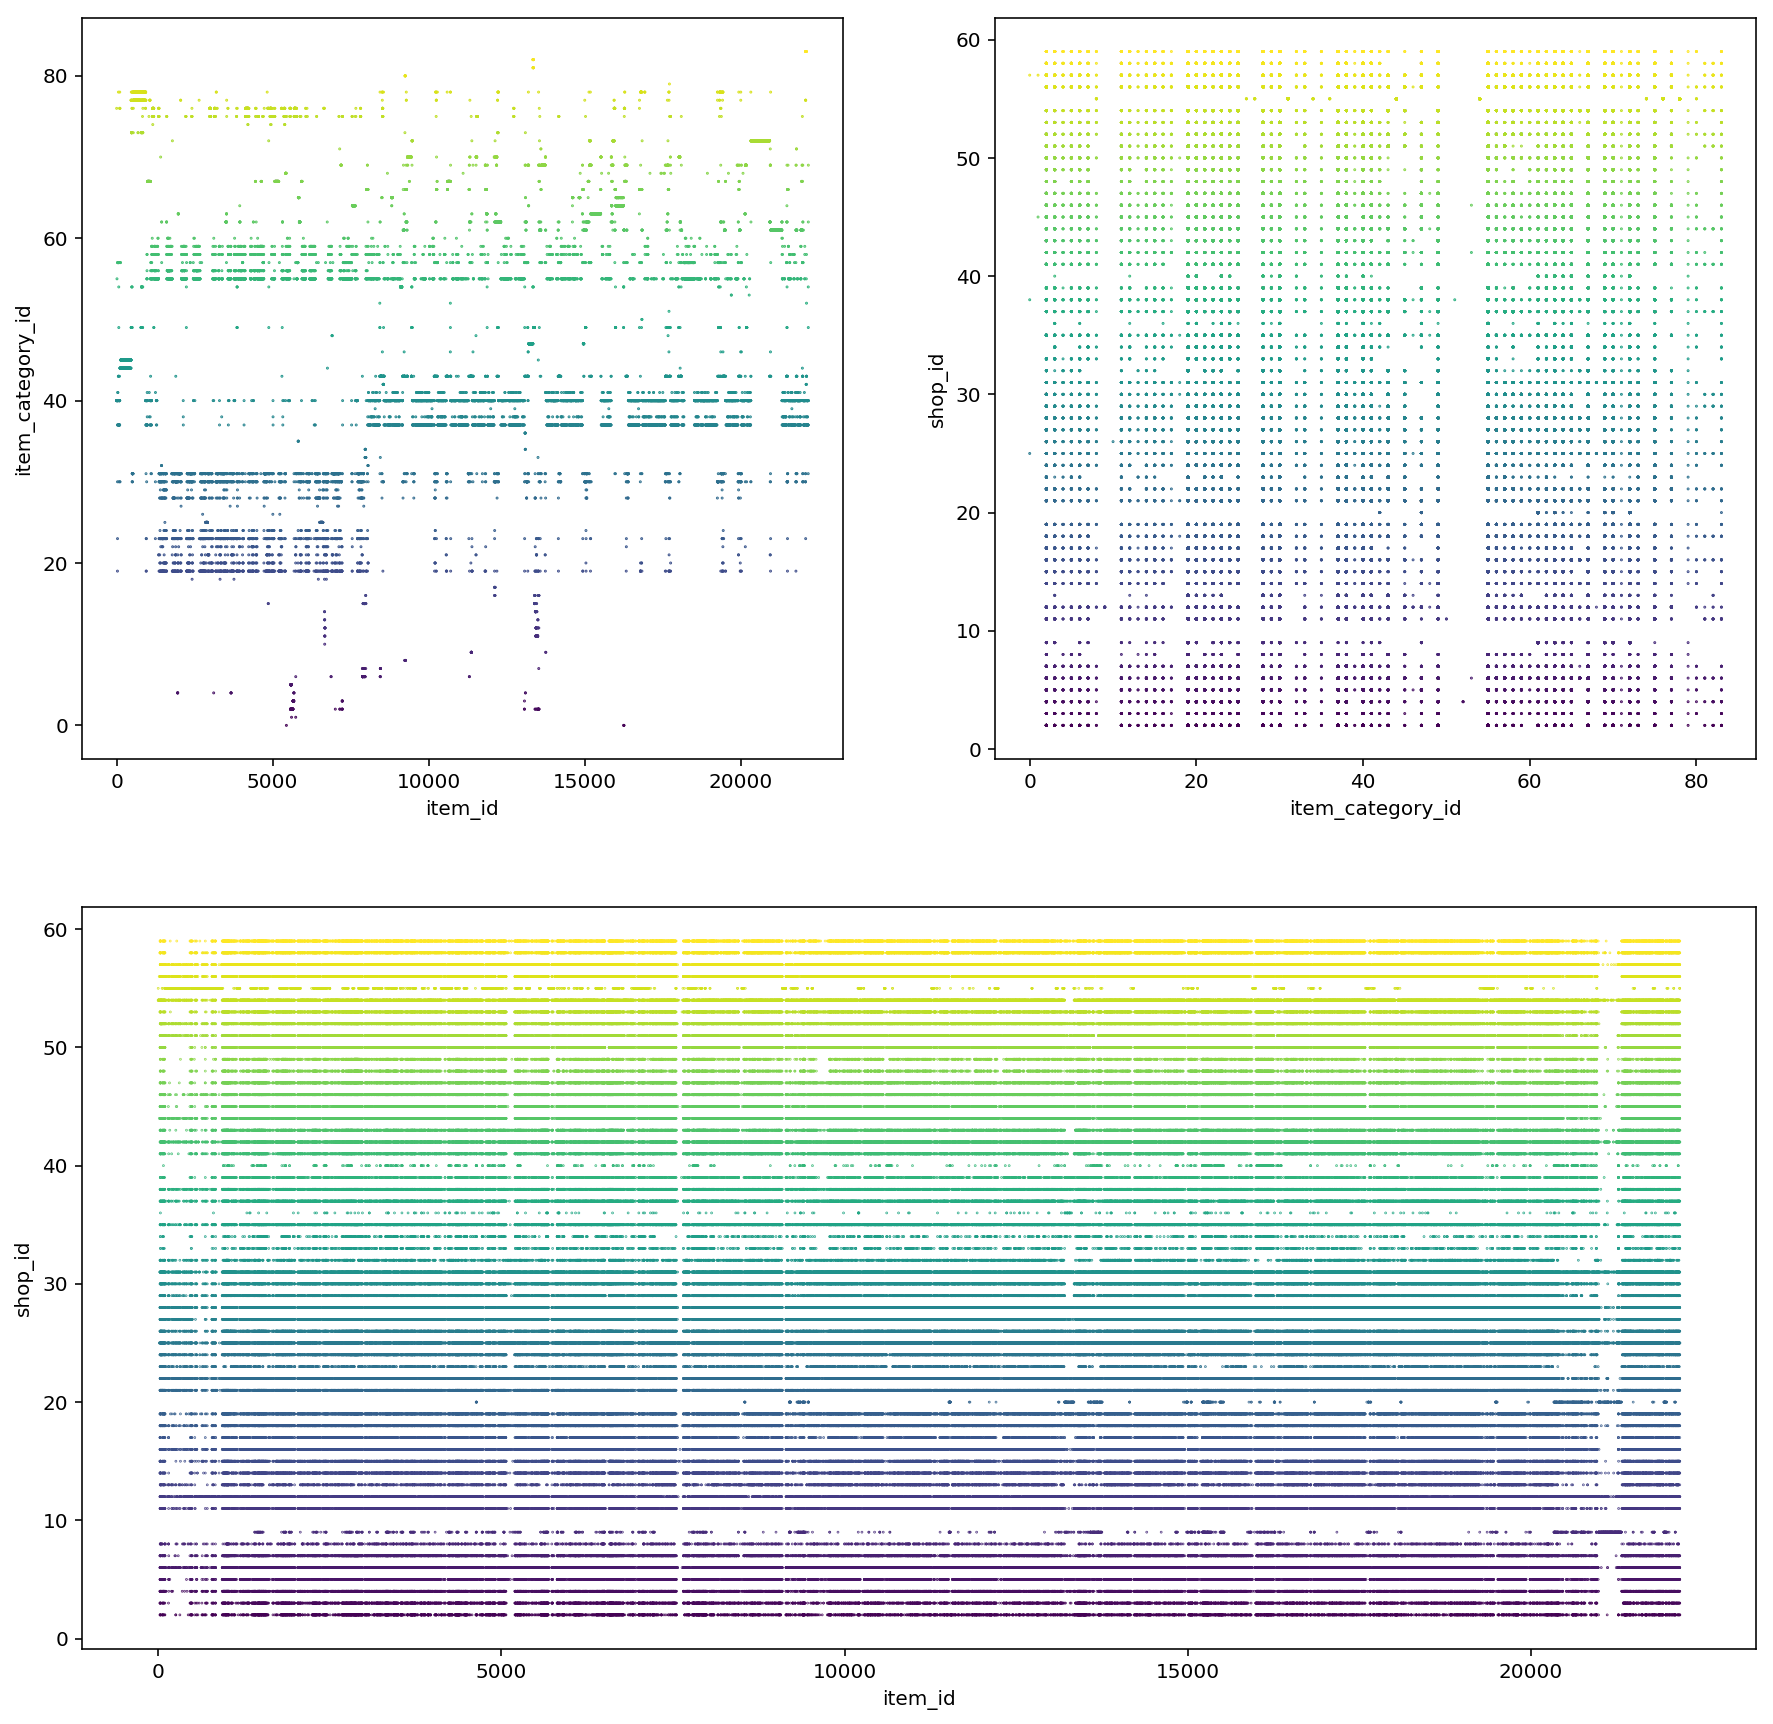

In [145]:
# # plt the item_id vs item_category_id, item_id vs shop_id, item_category_id vs shop_id
%config InlineBackend.figure_format ='retina'
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.2);

plt.figure(figsize=(15, 15));
plt.subplot(grid[0, 0]);
#plt.subplot(1,3,1)
plt.scatter(items.item_id,items.item_category_id, s=0.2, c=items.item_category_id,marker = 'o');
plt.xlabel('item_id');
plt.ylabel('item_category_id');

plt.subplot(grid[1, :2]);
#plt.subplot(1,3,2);
plt.scatter(item_shop['item_id'],item_shop['shop_id'], s=0.1, c=item_shop.shop_id,marker = 'o');
plt.xlabel('item_id');
plt.ylabel('shop_id');

plt.subplot(grid[0, 1:]);
#plt.subplot(1,3,3);
plt.scatter(item_shop['item_category_id'],item_shop['shop_id'], s=0.2, c=item_shop.shop_id,marker = 'o');
plt.xlabel('item_category_id');
plt.ylabel('shop_id');

The above figures give an overall impression of how the item_id, item_category_id, shop_id are related to each other. The item_id doesn't seem to be strictly follow category_id. For each category_id, the item_id is not consecutive. For the majority of shops, they sold items that cover most category_id, but exceptions can be found. Similar features can be found for item_id vs shop_id.



Below we can further analyse how the overal sales perform 

First, we check how the total sale looks like for the company for each item_category

In [173]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']
train = train.merge(items, on='item_id',how = 'left');
train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154      999.00           1.0   
1  03.01.2013               0       25     2552      899.00           1.0   
2  05.01.2013               0       25     2552      899.00          -1.0   
3  06.01.2013               0       25     2554     1709.05           1.0   
4  15.01.2013               0       25     2555     1099.00           1.0   

   revenue                                 item_name  item_category_id  
0   999.00                         ЯВЛЕНИЕ 2012 (BD)                37  
1   899.00  DEEP PURPLE  The House Of Blue Light  LP                58  
2  -899.00  DEEP PURPLE  The House Of Blue Light  LP                58  
3  1709.05  DEEP PURPLE  Who Do You Think We Are  LP                58  
4  1099.00   DEEP PURPLE 30 Very Best Of 2CD (Фирм.)                56

In [147]:
# # We check the overall sales behavior of the company by item_category and month

company_sales_month = train.groupby(['date_block_num','item_category_id'])['revenue'].sum().unstack()
company_sales_month = company_sales_month.fillna(0)
company_sales_month.head()


# #del tran_item 

item_category_id     0      1           2          3          4          5   \
date_block_num                                                                
0                 148.0  148.0  2848554.48  209160.13  232099.00  629610.07   
1                  93.0  283.0  2503325.05  142217.00  177195.65  371501.40   
2                   0.0    0.0  2216149.50  146198.50  166571.70  401294.30   
3                  22.4    0.0  1387834.05   99370.00   96917.00  286375.70   
4                   0.0    0.0  1245530.70   74131.20  103603.40  252976.10   

item_category_id         6    7    8         9       10          11   12  \
date_block_num                                                             
0                 1489045.1  0.0  0.0   98009.0     0.0  5098072.40  0.0   
1                 1180157.9  0.0  0.0  121692.0     0.0  3095180.30  0.0   
2                 1151109.6  0.0  0.0  193539.0     0.0  3145907.80  0.0   
3                  791113.4  0.0  0.0   94517.0  1998.0  2457793.95  0.0   
4                  756660.2  0.0  0.0   83013.0     0.0  1888231.15  0.0   

item_category_id         13          14          15   16   17      18  \
date_block_num                                                          
0                 412803.77  1618033.42  3583623.63  0.0  0.0  1194.0   
1                 373010.80  1145594.00  2929697.90  0.0  0.0   398.0   
2                 344075.90  1049681.70  2430071.30  0.0  0.0   796.0   
3                 154089.20   665422.60  1762359.65  0.0  0.0     0.0   
4                 135692.40   877310.60  1411752.50  0.0  0.0     0.0   

item_category_id           19   20          21          22          23   24  \
date_block_num                                                                
0                 14095791.59  0.0  2113069.76  2171739.36  7662671.66  0.0   
1                 15409061.79  0.0  1588729.80  1331531.05  8318403.05  0.0   
2                 20361014.03  0.0  1455075.80  1285106.10  8908642.25  0.0   
3                 11189530.85  0.0   983415.85   921459.50  5510219.85  0.0   
4                  9959255.65  0.0  1115657.70  1166755.60  5617510.80  0.0   

item_category_id         25   26   27          28          29           30  \
date_block_num                                                               
0                 479689.06  0.0  0.0  3786457.49   558063.08  10012799.96   
1                 377250.10  0.0  0.0  5068739.29   967632.50  11035022.39   
2                 438120.50  0.0  0.0  7599013.03  2355761.80  14121091.32   
3                 417635.50  0.0  0.0  3509744.75   436854.35   7686473.80   
4                 490089.65  0.0  0.0  2375110.80  1430052.20   8684749.50   

item_category_id         31   32         33   34         35   36          37  \
date_block_num                                                                 
0                      0.00  0.0  421831.90  0.0  521444.48  0.0  2845049.46   
1                      0.00  0.0  510360.00  0.0  529694.00  0.0  3201224.25   
2                      0.00  0.0  465420.65  0.0  752265.40  0.0  3103720.55   
3                      0.00  0.0  394254.00  0.0  689771.00  0.0  3253856.47   
4                 215448.87  0.0  335573.00  0.0  665891.20  0.0  2849666.24   

item_category_id          38   39           40          41   42         43  \
date_block_num                                                               
0                 1660852.19  0.0   8667236.69  1782934.68  0.0  406827.80   
1                 1249961.53  0.0   8482273.93  2117563.39  0.0  452897.35   
2                 1398613.93  0.0  10054256.65  1817692.85  0.0  469370.60   
3                 1621286.26  0.0   7464270.35  1264705.22  0.0  364899.05   
4                  868408.82  0.0   6607700.00  1432391.59  0.0  314968.50   

item_category_id     44       45     46   47     48        49   50   51  \
date_block_num                                                            
0                   0.0  83313.0  229.0  0

Text(0.5,1,'Relative change of monthly sales by item category')

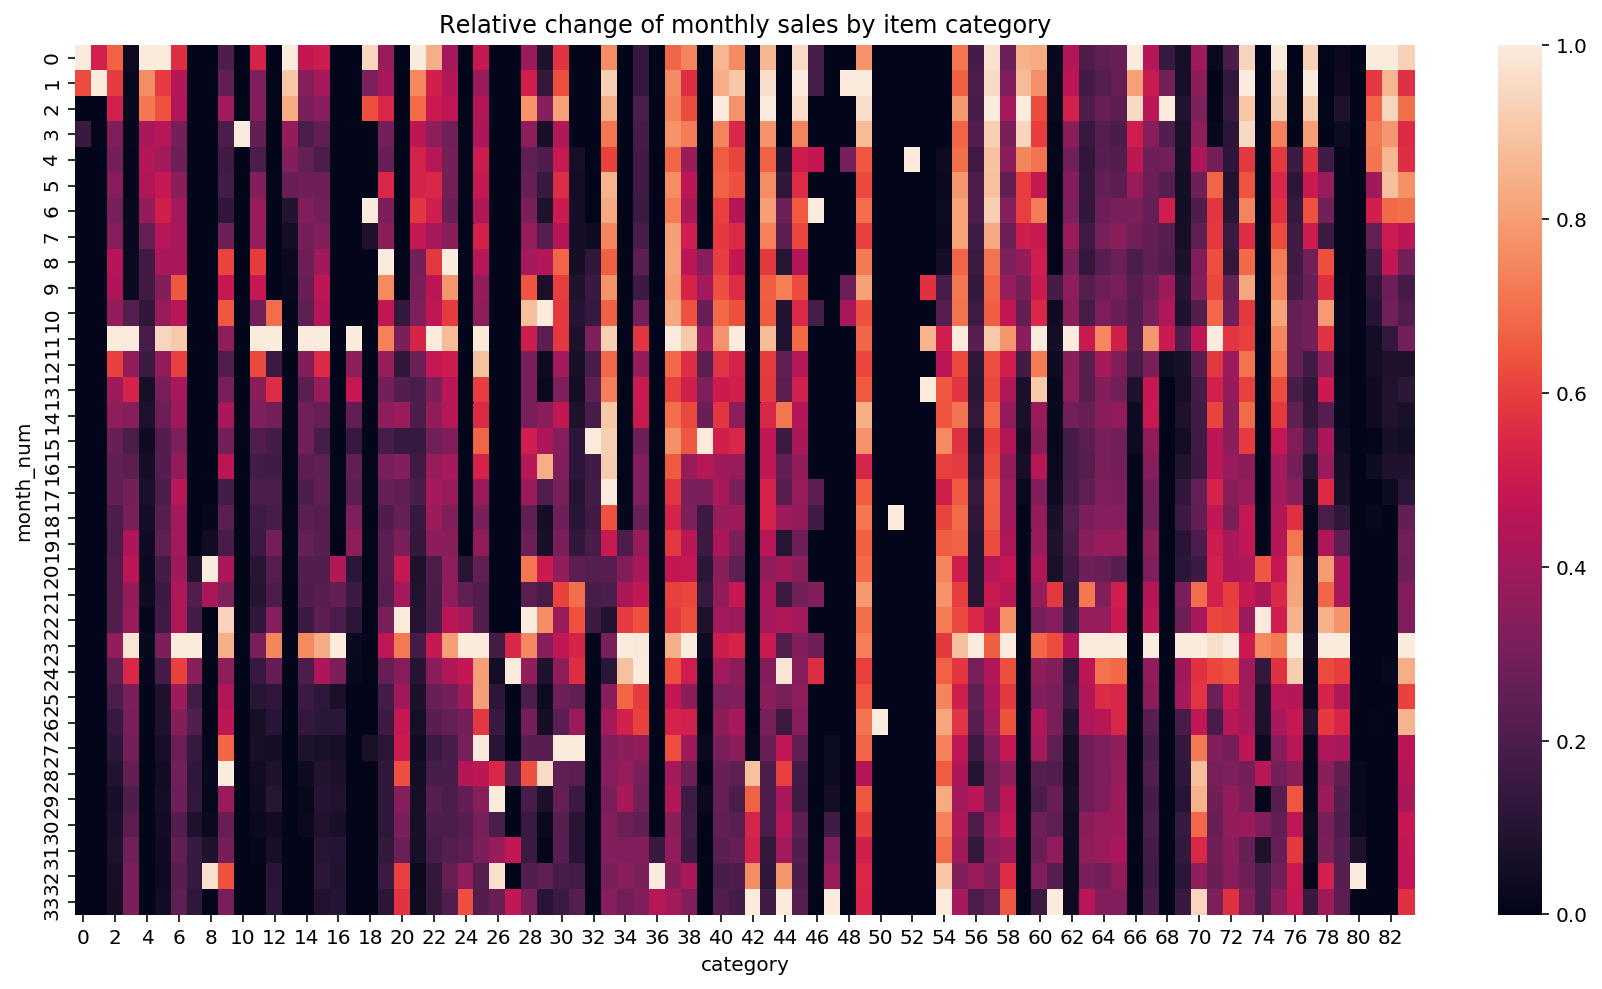

In [148]:
# # we visualize how the sales change relatively for each category over the past 33 months
plt.figure (figsize=(15, 8))
sns.heatmap(company_sales_month/company_sales_month.iloc[:,:].max())
plt.ylabel('month_num')
plt.xlabel('category')
plt.title('Relative change of monthly sales by item category')

It is quite clear that different categories have different behaviors: 1. some categories have rather consistent sales, like category 49; 2. some are quite random and only have sales for one or two months over the past 34 months, like category 50 to 52; 3. some have seasonal patterns, with sales peaks around the end of years, like 76; 4. some have gradually decreasing sales, like 81,82, possibily because they are no longer in sales; 5. some have emerging sales, like 47, probably because they are recent new products.

Below are some exemplary sales patterns of different item_categories.

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


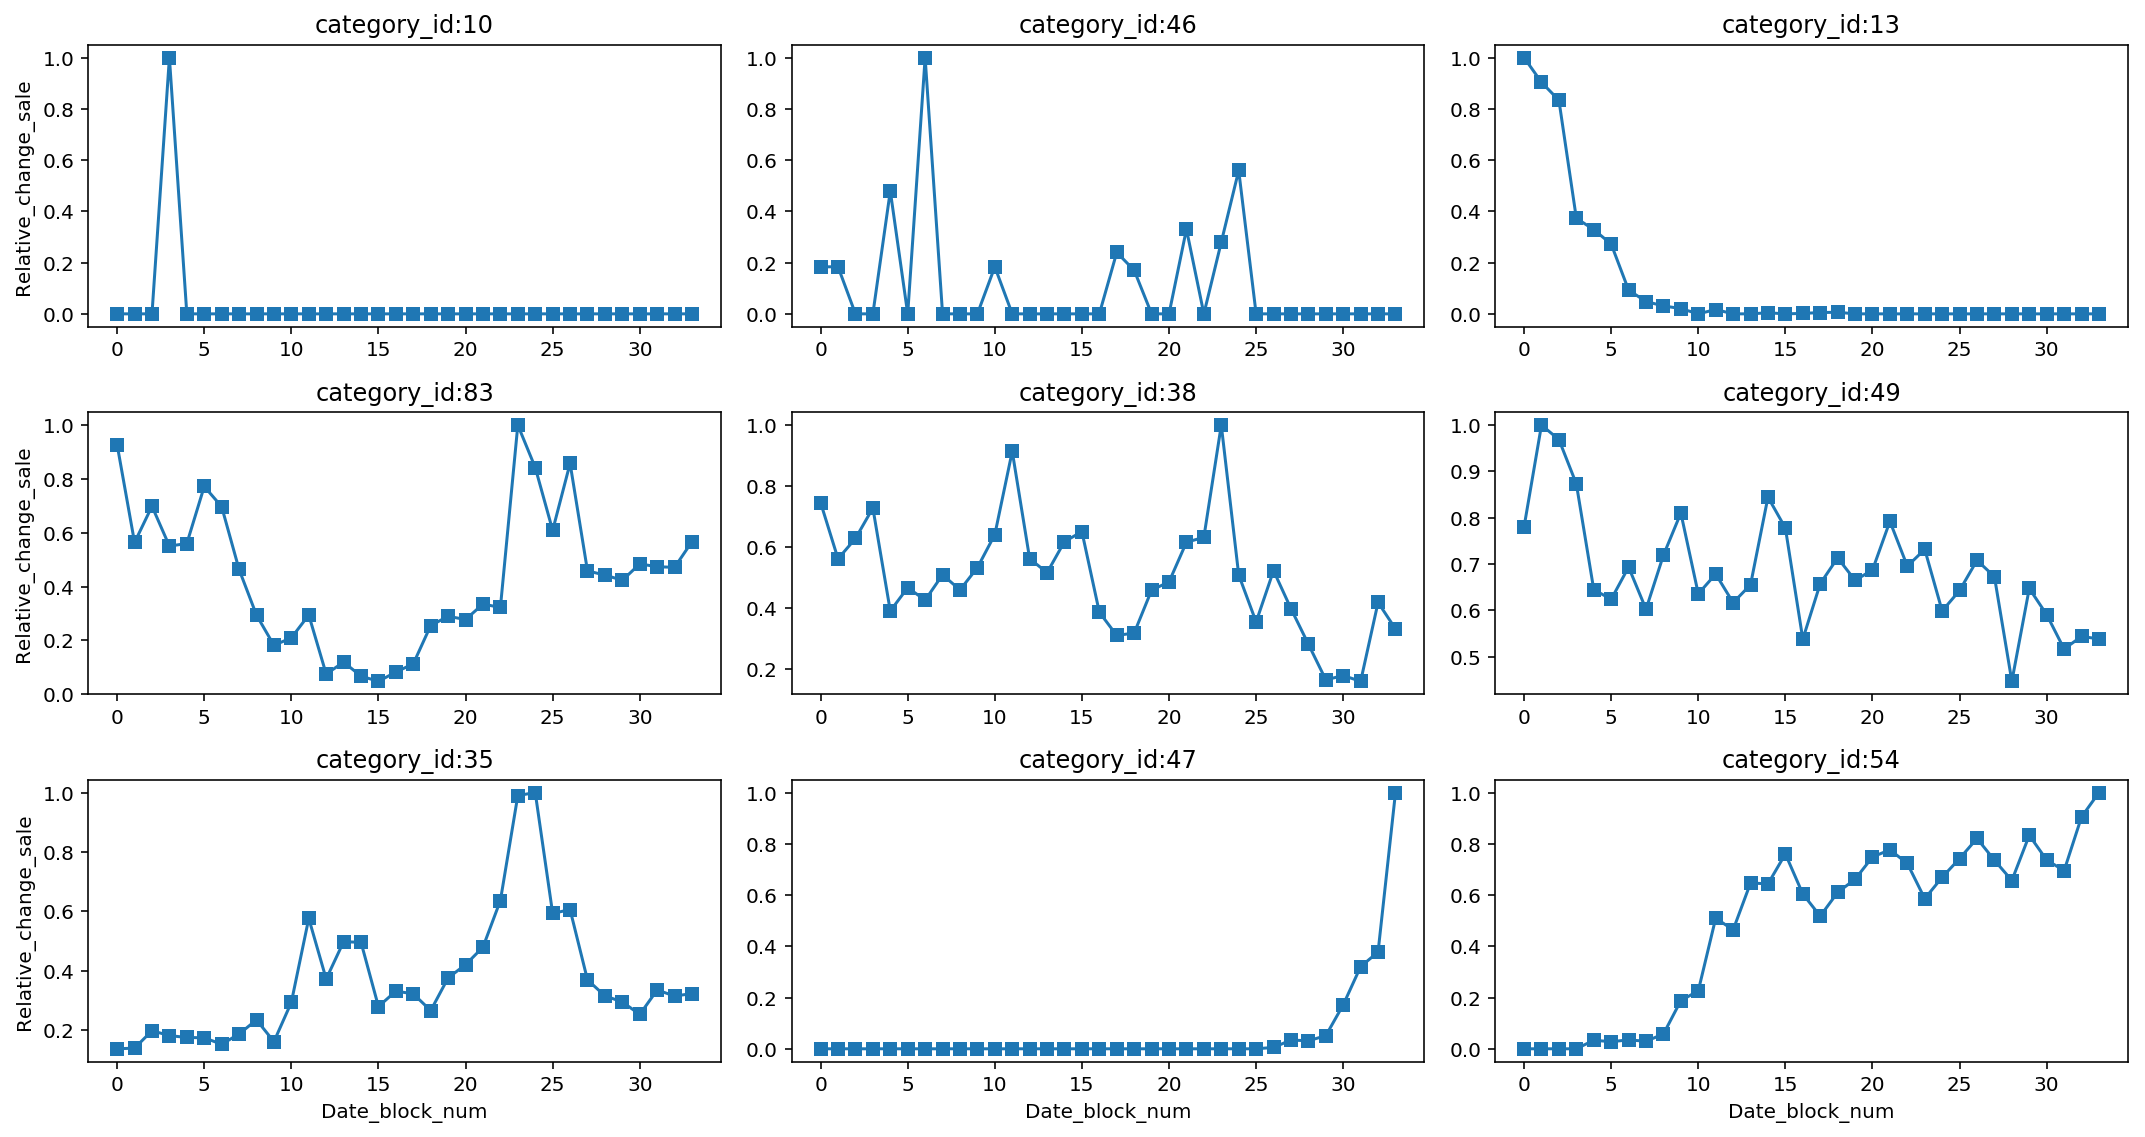

In [155]:
plt.figure(figsize = (15,8), tight_layout = True)
cat_chosen = [10, 46, 13,83, 38, 49,35, 47, 54]
for i in range(9):
    plt.subplot(3,3,i+1);
    plt.plot(company_sales_month[cat_chosen[i]]/company_sales_month[cat_chosen[i]].max(),marker = 's');
    
    if i>=6:
        plt.xlabel('Date_block_num');
    if i in [0,3,6]:
        plt.ylabel('Relative_change_sale');
    plt.title('category_id:'+str(cat_chosen[i])) ;


Next, we check how the total sales of different stores change

In [156]:
# # We check the sales behavior of each shop by month

shop_sales_month = train.groupby(['date_block_num','shop_id'])['revenue'].sum().unstack()
shop_sales_month = shop_sales_month.fillna(0)
shop_sales_month.head()


shop_id                2          3          4         5          6   \
date_block_num                                                         
0               1085064.8  560585.01  1433666.0       0.0  2743015.0   
1                522339.0  584394.00  1532115.0  522065.0  2919700.0   
2                732950.0  635652.00  1415445.5  813914.0  3407397.0   
3                614860.0  399668.00   202647.0  646772.0  2097684.0   
4                542429.0  470182.00   917357.0  629038.5  1912973.0   

shop_id                7         8    9         11          12        13  \
date_block_num                                                             
0               1870467.0  952881.0  0.0  577494.0   996495.75  225435.0   
1               1900439.0  762880.0  0.0  636783.0  1370670.70  226880.0   
2               2003825.0  634196.0  0.0  596111.0  1893864.10  311521.0   
3                999180.5    -599.0  0.0  368563.0  1360277.45  240835.0   
4               1050426.0       0.0  0.0  353021.0  1115095.60  225950.0   

shop_id                14         15         16   17         18          19  \
date_block_num                                                                
0               1264646.0  2024127.0  1999620.5  0.0  2742707.0  2118666.55   
1               1270446.5  2011249.0  1737058.0  0.0  3066448.0  1859942.00   
2               1358005.0  1998164.6  1996357.0  0.0  3304036.7  1937416.00   
3                858036.0  1381703.0  1262198.0  0.0  2247598.0  1430535.00   
4                881561.0  1255709.0  1230459.0  0.0  2443014.0  1206345.00   

shop_id          20         21         22         23          24          25  \
date_block_num                                                                 
0               0.0   841233.0  1424002.0  1372494.6  1432248.87  5376478.13   
1               0.0  1240899.0  2156821.0  1442296.0  1485892.00  5530463.20   
2               0.0  1523218.0  2127816.5  1616183.5  1594324.00  6655983.20   
3               0.0  1110802.0  1611993.3  1190547.1   585713.00  4772728.00   
4               0.0   930671.0  1160717.4        0.0  1580318.50  4171683.60   

shop_id                 26         27          28         29         30  \
date_block_num                                                            
0               1563004.00  4728830.0  4718191.23  2168116.5  1956150.0   
1               1851317.20  3758637.0  3705912.00  2167254.0  1718723.4   
2               2510813.00  4378750.0  4581680.03  2450778.0  1950701.0   
3               1498057.05  2863535.0  3128389.00  1490835.5  1304730.0   
4               1418438.30  2391418.0  3173811.00  1319746.0  1235429.5   

shop_id                 31         32   33   34          35   36         37  \
date_block_num                                                                
0               6334218.71   824625.0  0.0  0.0  1462381.00  0.0  1615042.0   
1               7033617.00  1007056.0  0.0  0.0  1563485.00  0.0  1595653.0   
2               7977839.22  1314416.0  0.0  0.0  1917339.51  0.0  1879192.0   
3               5618394.00   872569.0  0.0  0.0  1213042.55  0.0  1281399.0   
4               5230774.00   741036.0  0.0  0.0  1293750.00  0.0  1175788.0   

shop_id                 38   39   40         41         42          43  \
date_block_num                                                           
0               1792861.90  0.0  0.0  1839504.0  3031275.0  1625651.50   
1               1581008.00  0.0  0.0  1788033.0  3206216.5  1937215.00   
2               1918332.83  0.0  0.0  1440679.0  4119367.0  2470122.50   
3               1256294.50  0.0  0.0   910881.0  2780866.0  1528576.00   
4               1126123.00  0.0  0.0   923104.0  2473298.0  1214115.49   

shop_id                44         45         46         47   48   49  \
date_block_num                                                         
0                913969.0  1241908.0  2358348.0  1820901.0  0.0  0.0   
1               1030422.0  11709

Text(0.5,1,'Relative change of monthly sales by shop')

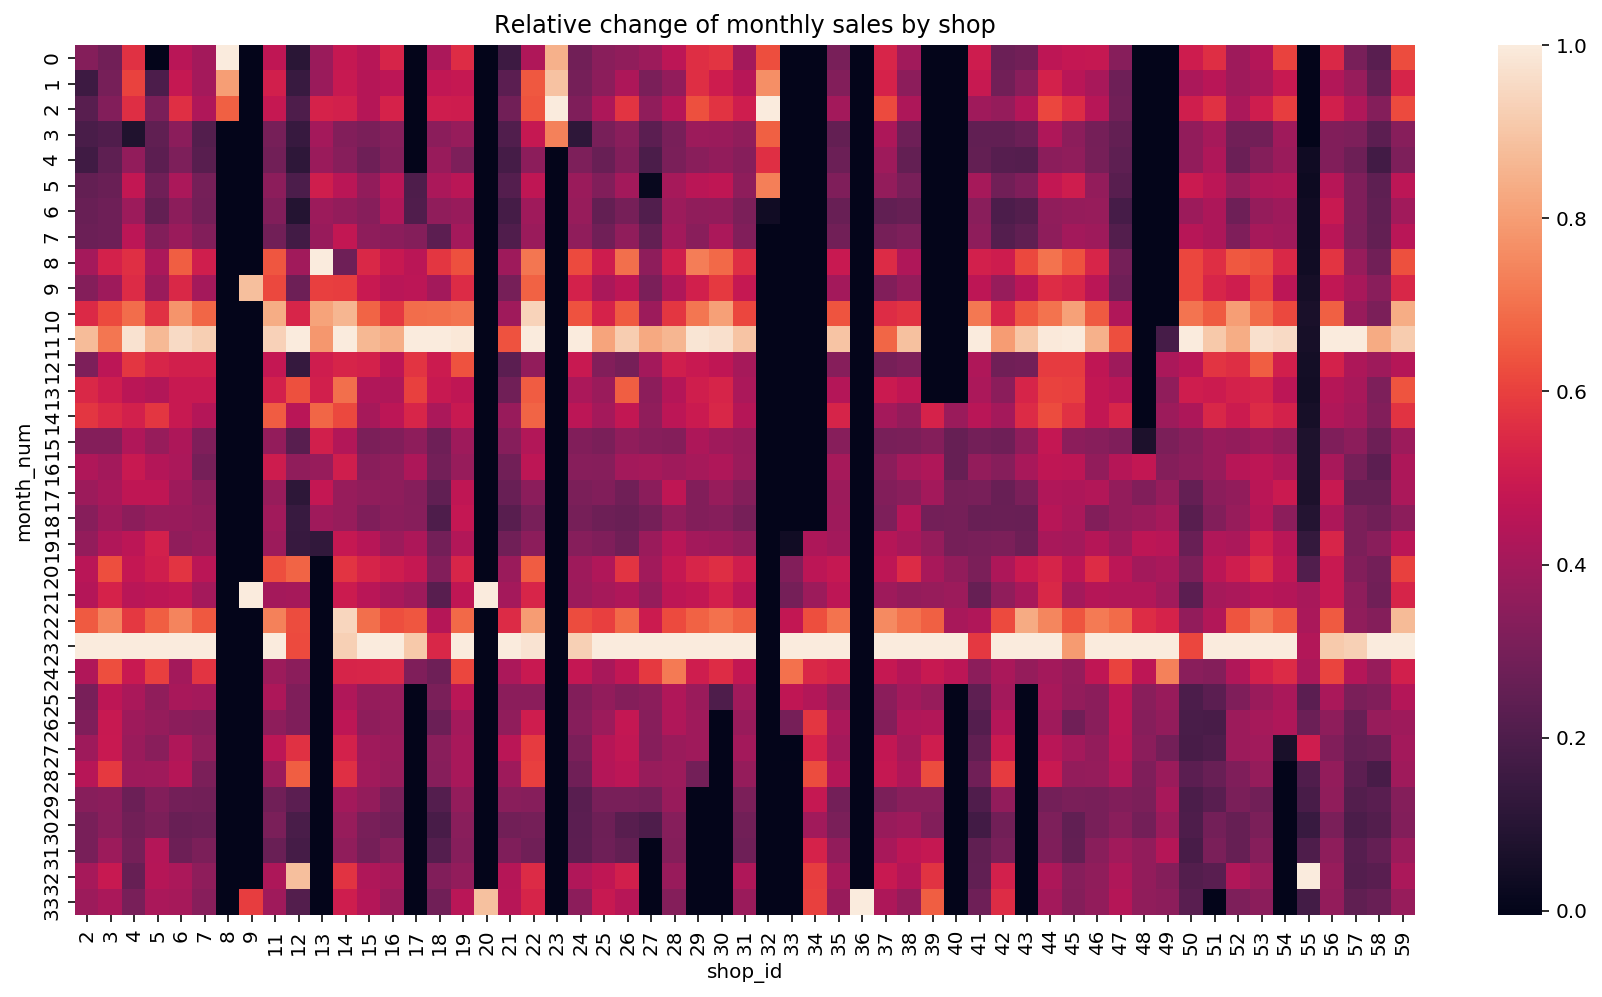

In [157]:
# # we visualize how the sales change relatively for each category over the past 33 months
plt.figure (figsize=(15, 8))
sns.heatmap(shop_sales_month/shop_sales_month.iloc[:,:].max())
plt.ylabel('month_num')
plt.xlabel('shop_id')
plt.title('Relative change of monthly sales by shop')

We notice some of the shops have zero sales over at least the past month, it could means these shops had been closed.

In [158]:
shop_zero = shop_sales_month.loc[:,shop_sales_month.iloc[-1,:]==0].columns
shop_zero

Int64Index([8, 13, 17, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54], dtype='int64', name='shop_id')

Before we start modeling and predicting sales, we need to check the test data sets and see if any shop_id is likely to be the 'closed' one, or if any item_id is in the test but not the train set.

In [159]:
test_shop = pd.DataFrame(data = test.shop_id.unique(), index = test.shop_id.unique(),columns = ['test_shop'])
close_shop = pd.DataFrame(data = np.array(shop_zero), index = shop_zero,columns = ['closed_shop'])

comp_shop = pd.concat([test_shop,close_shop], axis=1)
comp_shop


test_shop  closed_shop
2         2.0          NaN
3         3.0          NaN
4         4.0          NaN
5         5.0          NaN
6         6.0          NaN
7         7.0          NaN
8         NaN          8.0
10       10.0          NaN
12       12.0          NaN
13        NaN         13.0
14       14.0          NaN
15       15.0          NaN
16       16.0          NaN
17        NaN         17.0
18       18.0          NaN
19       19.0          NaN
21       21.0          NaN
22       22.0          NaN
23        NaN         23.0
24       24.0          NaN
25       25.0          NaN
26       26.0          NaN
27        NaN         27.0
28       28.0          NaN
29        NaN         29.0
30        NaN         30.0
31       31.0          NaN
32        NaN         32.0
33        NaN         33.0
34       34.0          NaN
35       35.0          NaN
36       36.0          NaN
37       37.0          NaN
38       38.0          NaN
39       39.0          NaN
40        NaN         40.0
41       41.0          NaN
42       42.0          NaN
43        NaN         43.0
44       44.0          NaN
45       45.0          NaN
46       46.0          NaN
47       47.0          NaN
48       48.0          NaN
49       49.0          NaN
50       50.0          NaN
51        NaN         51.0
52       52.0          NaN
53       53.0          NaN
54        NaN         54.0
55       55.0          NaN
56       56.0          NaN
57       57.0          NaN
58       58.0          NaN
59       59.0          NaN

Clearly, the ones we picked up that were likely closed are exactly the ones that are not listed in the test data set. It's good to know why they are filtered. 

We further check if there is any item in the test set not listed in the train set.

In [161]:
# # first we create a shop/item pair
#item_shop['shop/item'] = item_shop.agg(lambda x: f"{x['shop_id']}/{x['item_id']}", axis=1)
                                      
#test['shop/item'] = test.agg(lambda x: f"{x['shop_id']}/{x['item_id']}", axis=1)

item_shop['shop/item'] = item_shop['shop_id'].astype(str)+'/'+item_shop['item_id'].astype(str)
test['shop/item'] = test['shop_id'].astype(str)+'/'+test['item_id'].astype(str)
item_shop.head()
item_shop.shape
test.head()
test.shape

(214200, 3)

In [162]:
# # check if shop/item pair in test is new
test['is_new_set'] = test[['shop/item']].join(item_shop[['shop/item']].set_index('shop/item'), on='shop/item', how='inner').isna()*1
test['is_new_set'] = test['is_new_set'].fillna(1)

# check if the item is new
item_unique = pd.DataFrame(item_shop['item_id'].unique())
item_unique.columns = ['item_id']

test['is_new_item'] = test[['item_id']].join(item_unique[['item_id']].set_index('item_id'), on='item_id', how='inner').isna()*1
test['is_new_item'] = test['is_new_item'].fillna(1)


test.head(10)
print('Total number of shop/item pairs:',test['shop/item'].shape[0])
print('Total number of unique shop/item pairs:',test['shop/item'].nunique())
print('Number of new shop/item pairs:',test['is_new_set'].sum())

print('Number of items:',test['item_id'].nunique())
print('Number of new items:',test['item_id'][test.is_new_item == 1].nunique())

Total number of shop/item pairs: 214200
Total number of unique shop/item pairs: 214200
Number of new shop/item pairs: 104881
Number of items: 5100
Number of new items: 363


Note that there are 21807 unique item_id in "transactions" and 22170 (= 21807 + 363) unique item_id in "items". 
The new 363 items in the test are the ones not in the train set but in the items.csv . 

<a id='Feature_Engineering'></a> 
## 3. [Feature Engineering](#Contents)

In [163]:
train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154      999.00           1.0   
1  03.01.2013               0       25     2552      899.00           1.0   
2  05.01.2013               0       25     2552      899.00          -1.0   
3  06.01.2013               0       25     2554     1709.05           1.0   
4  15.01.2013               0       25     2555     1099.00           1.0   

   revenue  item_category_id  
0   999.00                37  
1   899.00                58  
2  -899.00                58  
3  1709.05                58  
4  1099.00                56

Let's see how the price and item_cnt are distributed in different categories

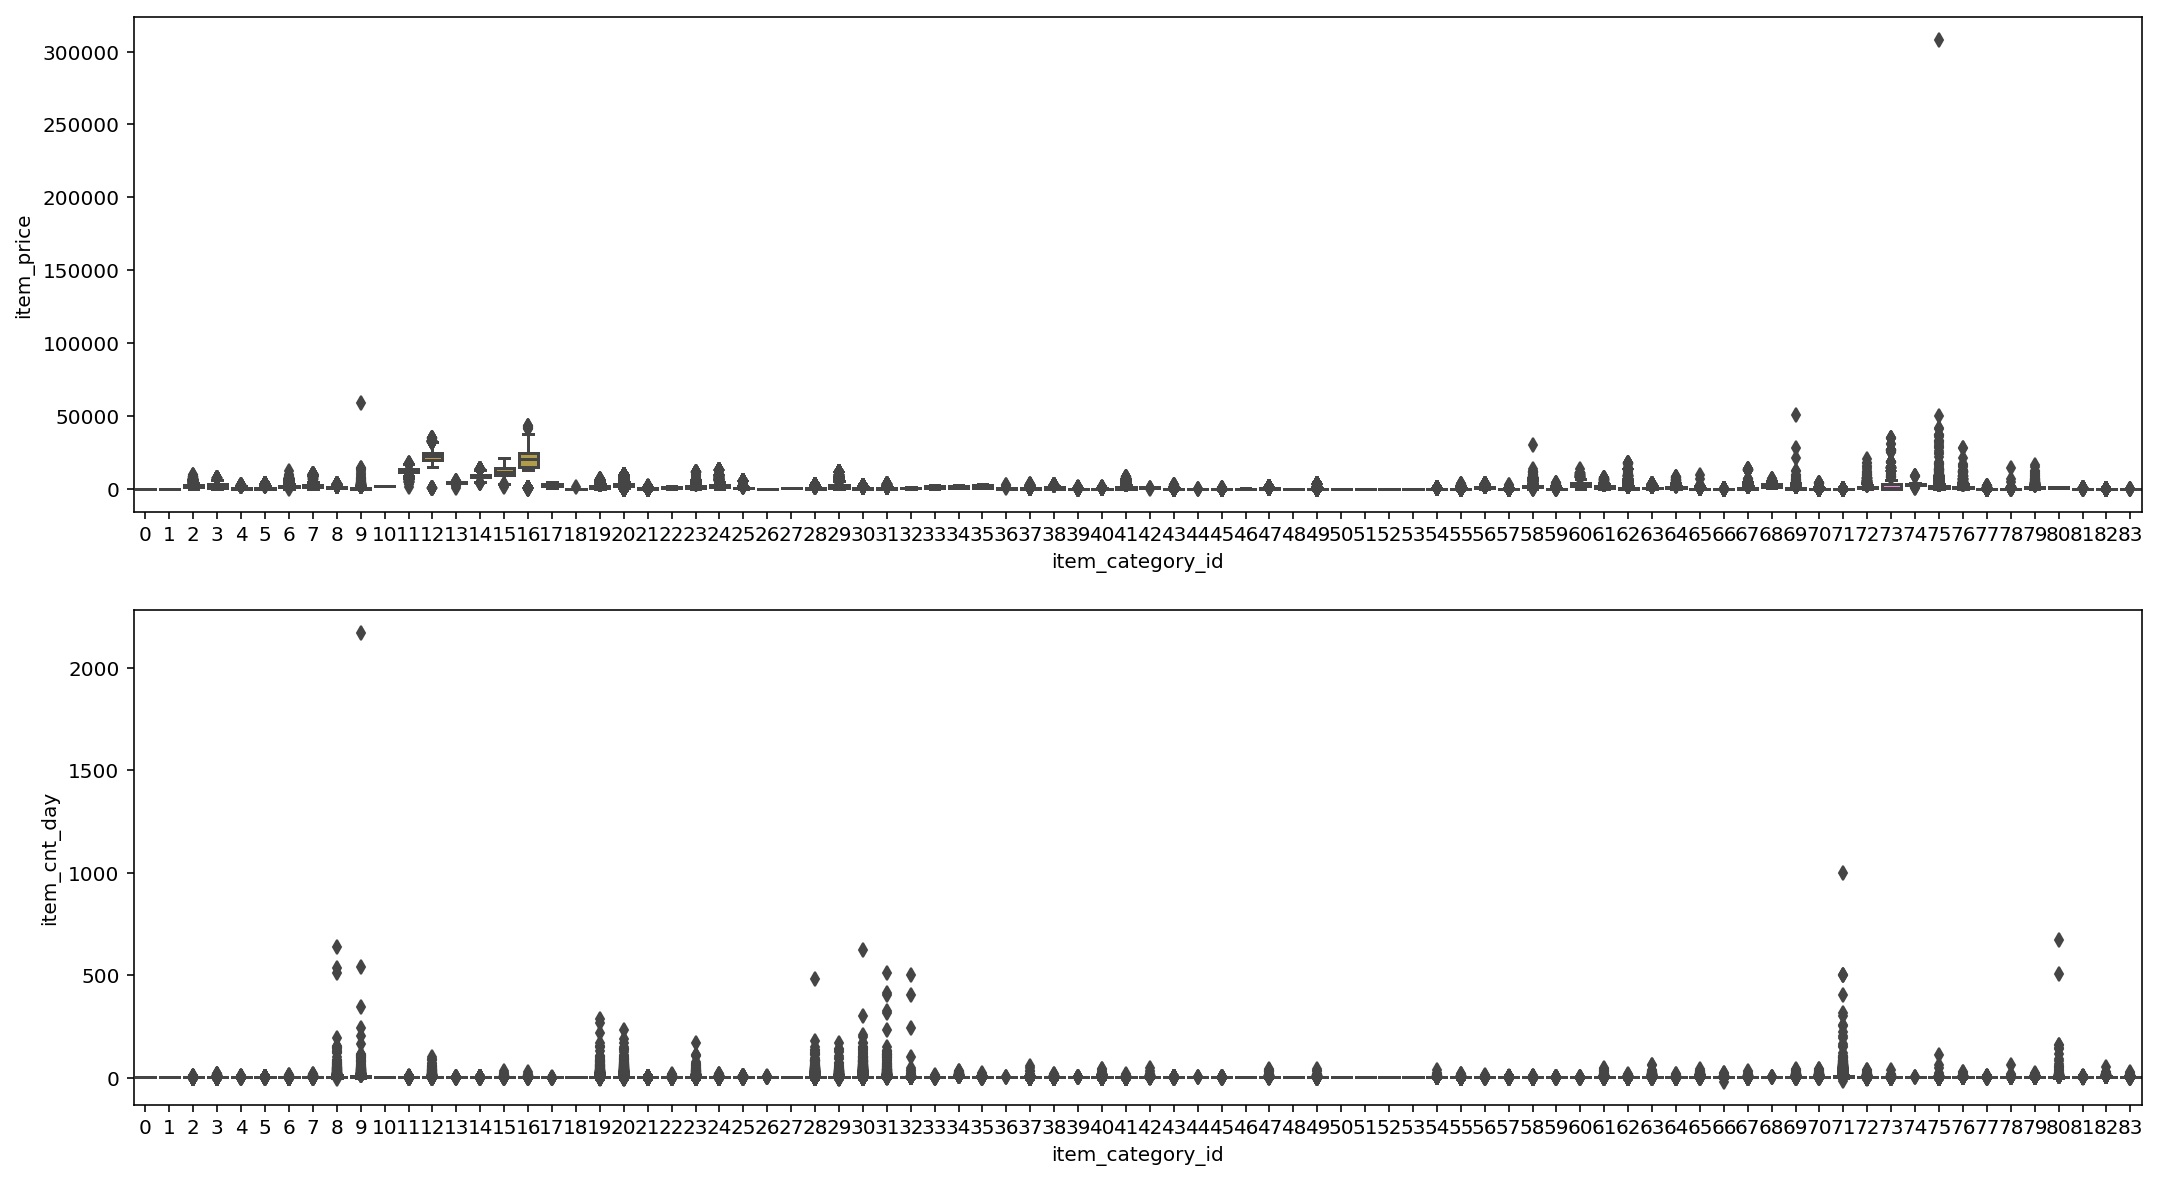

In [174]:
plt.figure(figsize = (18,10));
 
plt.subplot(2,1,1);
ax1 = sns.boxplot(y=train["item_price"], x=train["item_category_id"]);
#ax1.set_yscale('log');
#ax1.xticks(ticks=np.arange(0,83,2),labels=np.arange(0,83,2) ) ;
#plt.title()

plt.subplot(2,1,2);
ax2 = sns.boxplot(y=train["item_cnt_day"], x=train["item_category_id"]);
#ax2.set_yscale('log');
#ax2.xticks(ticks=np.arange(0,83,2),labels=np.arange(0,83,2) ) ;


plt.show();

In [23]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [24]:
train.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935847e+06  2.935847e+06  2.935847e+06  2.935847e+06  2.935847e+06
mean     1.456991e+01  3.300174e+01  1.019723e+04  8.907489e+02  1.241903e+00
std      9.422985e+00  1.622697e+01  6.324299e+03  1.720490e+03  2.292963e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  5.920000e+04  1.000000e+03

In [25]:
# see what are the rows with a negative price
train [train ['item_price'] <=0]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0

In [26]:
# check related transactions from the same shop for the same item_id
train[(train.shop_id == 32) & (train.item_id == 2973)]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
67427   29.01.2013               0       32     2973      2499.0           1.0
67428   25.01.2013               0       32     2973      2499.0           1.0
67429   22.01.2013               0       32     2973      2499.0           1.0
67430   21.01.2013               0       32     2973      2499.0           1.0
67431   18.01.2013               0       32     2973      2499.0           1.0
67432   17.01.2013               0       32     2973      2499.0           1.0
67433   15.01.2013               0       32     2973      2499.0           3.0
187844  05.02.2013               1       32     2973      2499.0           1.0
187845  14.02.2013               1       32     2973      2499.0           1.0
484682  23.05.2013               4       32     2973      1249.0           1.0
484683  15.05.2013               4       32     2973        -1.0           1.0
484684  06.05.2013               4       32     2973      2499.0           1.0
555026  05.06.2013               5       32     2973      1249.5           1.0

We see that in May 2013, the item_price changed from 2499 to 1249 for a possible clear out sales event (which ends after June 2013). It's not obvious what price we should choose for the missing price in the middle of the month. We therefore just choose to use median price, 2499.

In [27]:
med = train[(train.shop_id == 32) & (train.item_id == 2973) & (train.item_price > 0 ) ]['item_price'].median()
train.loc[train.item_price<0, 'item_price'] = med
train[(train.shop_id == 32) & (train.item_id == 2973) ]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
67427   29.01.2013               0       32     2973      2499.0           1.0
67428   25.01.2013               0       32     2973      2499.0           1.0
67429   22.01.2013               0       32     2973      2499.0           1.0
67430   21.01.2013               0       32     2973      2499.0           1.0
67431   18.01.2013               0       32     2973      2499.0           1.0
67432   17.01.2013               0       32     2973      2499.0           1.0
67433   15.01.2013               0       32     2973      2499.0           3.0
187844  05.02.2013               1       32     2973      2499.0           1.0
187845  14.02.2013               1       32     2973      2499.0           1.0
484682  23.05.2013               4       32     2973      1249.0           1.0
484683  15.05.2013               4       32     2973      2499.0           1.0
484684  06.05.2013               4       32     2973      2499.0           1.0
555026  05.06.2013               5       32     2973      1249.5           1.0

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [28]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [29]:
train.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935847e+06  2.935847e+06  2.935847e+06  2.935847e+06  2.935847e+06
mean     1.456991e+01  3.331065e+01  1.019723e+04  8.907498e+02  1.241903e+00
std      9.422985e+00  1.613679e+01  6.324299e+03  1.720491e+03  2.292963e+00
min      0.000000e+00  2.000000e+00  0.000000e+00  7.000000e-02 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.800000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  5.920000e+04  1.000000e+03

## Data preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [30]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales
We notice that in the test set, the item_id are the same for each shop_id, which is a grid. However, in the train set, there are only records for sold or returned items. To mimic the form of the test set,we should also create a grid for the items ever been sold for each shop, and merge the matrix with it.


In [31]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [32]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

matrix.head()
time.time() - ts

21.450410842895508

In [33]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

## Test set
To use time tricks append test pairs to the matrix.

In [34]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [35]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.02675318717956543

In [36]:
#matrix.tail()

## Shops/Items/Cats features

In [37]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

6.792234659194946

## Lags function

In [38]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [39]:
train.item_cnt_day.sum()

3646036.0

In [40]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['shop_item_cnt_month_sum']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['shop_item_cnt_month_sum'] = (matrix['shop_item_cnt_month_sum']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

time.time() - ts

matrix.head()

date_block_num  shop_id  item_id  city_code  item_category_id  type_code  \
0               0        2       19          0                40         11   
1               0        2       27          0                19          5   
2               0        2       28          0                30          8   
3               0        2       29          0                23          5   
4               0        2       32          0                40         11   

   subtype_code  shop_item_cnt_month_sum  
0             4                      0.0  
1            10                      1.0  
2            55                      0.0  
3            16                      0.0  
4             4                      0.0

In [41]:
#total monthly sale of item in the shop
col = ['date_block_num','shop_id','item_id']
group = train.groupby(col).agg({"revenue":"sum"})
group.reset_index(inplace = True)
group = group.rename(columns = {"revenue":"shop_item_transaction_month_sum"})
matrix = pd.merge(matrix,group, on = col, how = "left",copy=False)
matrix['shop_item_transaction_month_sum'] = matrix['shop_item_transaction_month_sum'].astype(np.float16)

# averaged selling price (transaction) per item
matrix['shop_item_price_month_ave'] = matrix['shop_item_transaction_month_sum']/matrix['shop_item_cnt_month_sum']
matrix['shop_item_price_month_ave']=matrix['shop_item_price_month_ave'].fillna(0)


matrix['shop_item_price_month_ave']=matrix['shop_item_price_month_ave'].astype(np.float16)
# # relative change of price within a month
# group = train.groupby(col).agg({"item_price":"max"}) - train.groupby(col).agg({"item_price":"min"})
# group.reset_index(inplace = True)
# group.rename(columns = {"item_price":"shop_item_price_month_var"},inplace = True)

# matrix = pd.merge(matrix,group, on = col, how = "left",copy=False)
# matrix.shop_item_price_month_var = matrix.shop_item_price_month_var/matrix.shop_item_price_month_ave

#matrix = lag_feature(matrix, [1,2], 'shop_item_price_month_ave')
#matrix = lag_feature(matrix, [1,2], 'shop_item_price_month_var')
matrix.head()


date_block_num  shop_id  item_id  city_code  item_category_id  type_code  \
0               0        2       19          0                40         11   
1               0        2       27          0                19          5   
2               0        2       28          0                30          8   
3               0        2       29          0                23          5   
4               0        2       32          0                40         11   

   subtype_code  shop_item_cnt_month_sum  shop_item_transaction_month_sum  \
0             4                      0.0                              NaN   
1            10                      1.0                           2500.0   
2            55                      0.0                              NaN   
3            16                      0.0                              NaN   
4             4                      0.0                              NaN   

   shop_item_price_month_ave  
0                        0.0  
1                     2500.0  
2                        0.0  
3                        0.0  
4                        0.0

In [42]:
matrix = matrix.replace([np.inf, -np.inf], np.nan).fillna(0)
#matrix.describe()

In [43]:

# averaged selling price of item for city
col = ['date_block_num','city_code','item_id']

group = matrix.groupby(col).agg({"shop_item_price_month_ave":"mean"})
group.reset_index(inplace = True)
group.rename(columns = {"shop_item_price_month_ave":"city_item_price_month_ave"},inplace = True)
matrix = pd.merge(matrix,group, on = col, how = "left",copy=False)


#matrix.describe()

In [44]:
# averaged selling price of item for company
col = ['date_block_num','item_id']

group = matrix.groupby(col).agg({"shop_item_price_month_ave":"mean"})
group.reset_index(inplace = True)
group.rename(columns = {"shop_item_price_month_ave":"company_item_price_month_ave"},inplace = True)
matrix = pd.merge(matrix,group, on = col, how = "left",copy=False)

In [45]:
# averaged yearly selling price of item for company
col = ['item_id']

group = matrix.groupby(col).agg({"shop_item_price_month_ave":"mean"})
group.reset_index(inplace = True)
group.rename(columns = {"shop_item_price_month_ave":"company_item_price_year_ave"},inplace = True)
matrix = pd.merge(matrix,group, on = col, how = "left",copy=False)

In [46]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'shop_item_cnt_month_sum')
time.time() - ts

43.827478647232056

In [47]:
###
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'company_item_price_month_ave')

for i in lags:
    matrix['delta_company_item_price_month_ave_lag_'+str(i)] = \
        (matrix['company_item_price_month_ave_lag_'+str(i)] - matrix['company_item_price_year_ave']) / matrix['company_item_price_year_ave']

def select_trend(row):
    for i in lags:
        if row['delta_company_item_price_month_ave_lag_'+str(i)]:
            return row['delta_company_item_price_month_ave_lag_'+str(i)]
    return 0
    
matrix['delta_company_item_price_month_ave_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_company_item_price_month_ave_lag'] = matrix['delta_company_item_price_month_ave_lag'].astype(np.float16)
matrix['delta_company_item_price_month_ave_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

#fetures_to_drop = ['company_item_price_year_ave', 'company_item_price_month_ave']
fetures_to_drop = []

for i in lags:
    fetures_to_drop += ['company_item_price_month_ave_lag_'+str(i)]
    fetures_to_drop += ['delta_company_item_price_month_ave_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

545.6286952495575

In [48]:
matrix = matrix.replace([np.inf, -np.inf], np.nan).fillna(0)
#matrix.describe()

## Mean encoded features

In [49]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'shop_item_cnt_month_sum': ['mean']})
group.columns = [ 'company_allitem_cnt_month_ave' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['company_allitem_cnt_month_ave'] = matrix['company_allitem_cnt_month_ave'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'company_allitem_cnt_month_ave')
#matrix.drop(['company_allitem_cnt_month_ave'], axis=1, inplace=True)
time.time() - ts

13.433825492858887

In [50]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'shop_item_cnt_month_sum': ['mean']})
group.columns = [ 'company_item_cnt_month_sum' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['company_item_cnt_month_sum'] = matrix['company_item_cnt_month_sum'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'company_item_cnt_month_sum')
#matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

54.11357045173645

In [51]:
#matrix.drop(['shop_allitem_cnt_month_ave_x','shop_allitem_cnt_month_ave_y'],axis = 1, inplace = True)

In [52]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'shop_item_cnt_month_sum': ['mean']})
group.columns = [ 'shop_allitem_cnt_month_ave' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['shop_allitem_cnt_month_ave'] = matrix['shop_allitem_cnt_month_ave'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'shop_allitem_cnt_month_ave')
#matrix.drop(['shop_allitem_cnt_month_ave'], axis=1, inplace=True)
time.time() - ts

58.290523052215576

In [53]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'shop_item_cnt_month_sum': ['mean']})
group.columns = [ 'company_item_cnt_month_sum_cat_ave' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['company_item_cnt_month_sum_cat_ave'] = matrix['company_item_cnt_month_sum_cat_ave'].astype(np.float16)
matrix = lag_feature(matrix, [1,2], 'company_item_cnt_month_sum_cat_ave')
#matrix.drop(['company_item_cnt_month_sum_cat_ave'], axis=1, inplace=True)
time.time() - ts

28.081750631332397

In [54]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'shop_item_cnt_month_sum': ['mean']})
group.columns = ['shop_item_cnt_month_sum_cat_ave']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['shop_item_cnt_month_sum_cat_ave'] = matrix['shop_item_cnt_month_sum_cat_ave'].astype(np.float16)
matrix = lag_feature(matrix, [1,2], 'shop_item_cnt_month_sum_cat_ave')
#matrix.drop(['shop_item_cnt_month_sum_cat_ave'], axis=1, inplace=True)
time.time() - ts

28.935840129852295

In [55]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'shop_item_cnt_month_sum': ['mean']})
group.columns = [ 'city_allitem_cnt_month_ave' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['city_allitem_cnt_month_ave'] = matrix['city_allitem_cnt_month_ave'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'city_allitem_cnt_month_ave')
#matrix.drop(['city_allitem_cnt_month_ave'], axis=1, inplace=True)
time.time() - ts

18.678050994873047

In [56]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'shop_item_cnt_month_sum': ['mean']})
group.columns = [ 'city_item_cnt_month_sum' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['city_item_cnt_month_sum'] = matrix['city_item_cnt_month_sum'].astype(np.float16)
matrix = lag_feature(matrix, [1,2], 'city_item_cnt_month_sum')
#matrix.drop(['shop_item_cnt_month_sum'], axis=1, inplace=True)
time.time() - ts

37.91031074523926

In [57]:
#matrix.describe()

In [58]:
colch = matrix.columns[matrix.dtypes == np.float64]
matrix[colch] = matrix[colch].astype(np.float16)
matrix.dtypes

date_block_num                                int64
shop_id                                       int64
item_id                                       int64
city_code                                     int64
item_category_id                              int64
type_code                                     int64
subtype_code                                  int64
shop_item_cnt_month_sum                     float16
shop_item_transaction_month_sum             float16
shop_item_price_month_ave                   float16
city_item_price_month_ave                   float16
company_item_price_month_ave                float16
company_item_price_year_ave                 float16
shop_item_cnt_month_sum_lag_1               float16
shop_item_cnt_month_sum_lag_2               float16
shop_item_cnt_month_sum_lag_3               float16
shop_item_cnt_month_sum_lag_6               float16
shop_item_cnt_month_sum_lag_12              float16
delta_company_item_price_month_ave_lag      float16
company_alli

In [59]:
matrix = matrix[matrix.date_block_num >11]

In [60]:
matrix.to_pickle('data.pkl')

In [61]:
matrix = pd.read_pickle('data.pkl')
matrix.head()

date_block_num  shop_id  item_id  city_code  item_category_id  \
4488710              12        2       27          0                19   
4488711              12        2       30          0                40   
4488712              12        2       31          0                37   
4488713              12        2       32          0                40   
4488714              12        2       33          0                37   

         type_code  subtype_code  shop_item_cnt_month_sum  \
4488710          5            10                      0.0   
4488711         11             4                      0.0   
4488712         11             1                      0.0   
4488713         11             4                      1.0   
4488714         11             1                      1.0   

         shop_item_transaction_month_sum  shop_item_price_month_ave  \
4488710                              0.0                        0.0   
4488711                              0.0                        0.0   
4488712                              0.0                        0.0   
4488713                            119.0                      119.0   
4488714                            199.0                      199.0   

         city_item_price_month_ave  company_item_price_month_ave  \
4488710                        0.0                     21.703125   
4488711                        0.0                     99.187500   
4488712                        0.0                    130.125000   
4488713                      119.0                     94.937500   
4488714                      199.0                     98.125000   

         company_item_price_year_ave  shop_item_cnt_month_sum_lag_1  \
4488710                      83.0625                            0.0   
4488711                      85.1250                            0.0   
4488712                     167.5000                            0.0   
4488713                     107.2500                            0.0   
4488714                      84.4375                            1.0   

         shop_item_cnt_month_sum_lag_2  shop_item_cnt_month_sum_lag_3  \
4488710                            0.0                            0.0   
4488711                            0.0                            0.0   
4488712                            0.0                            0.0   
4488713                            0.0                            0.0   
4488714                            2.0                            0.0   

         shop_item_cnt_month_sum_lag_6  shop_item_cnt_month_sum_lag_12  \
4488710                            0.0                             1.0   
4488711                            0.0                             0.0   
4488712                            0.0                             0.0   
4488713                            0.0                             0.0   
4488714                            0.0                             1.0   

         delta_company_item_price_month_ave_lag  \
4488710                                0.097046   
4488711                               -0.070496   
4488712                                0.165649   
4488713                               -0.080444   
4488714                                0.162109   

         company_allitem_cnt_month_ave  company_allitem_cnt_month_ave_lag_1  \
4488710                       0.311279                             0.411377   
4488711                       0.311279                             0.411377   
4488712                       0.311279                             0.411377   
4488713                       0.311279                             0.411377   
4488714                       0.311279                             0.411377   

         company_item_cnt_month_sum  company_item_cnt_month_sum_lag_1  \
4488710                    0.021744                          0.086975   
4488711                    1.260742                          1.021484   
4488712                    0.326172              

In [62]:
colch = matrix.columns[matrix.dtypes == np.int64]
matrix[colch] = matrix[colch].astype(np.int16)
matrix.dtypes 

date_block_num                                int16
shop_id                                       int16
item_id                                       int16
city_code                                     int16
item_category_id                              int16
type_code                                     int16
subtype_code                                  int16
shop_item_cnt_month_sum                     float16
shop_item_transaction_month_sum             float16
shop_item_price_month_ave                   float16
city_item_price_month_ave                   float16
company_item_price_month_ave                float16
company_item_price_year_ave                 float16
shop_item_cnt_month_sum_lag_1               float16
shop_item_cnt_month_sum_lag_2               float16
shop_item_cnt_month_sum_lag_3               float16
shop_item_cnt_month_sum_lag_6               float16
shop_item_cnt_month_sum_lag_12              float16
delta_company_item_price_month_ave_lag      float16
company_alli

In [63]:
matrix = matrix[matrix.date_block_num >11].fillna(0)
matrix.head()

date_block_num  shop_id  item_id  city_code  item_category_id  \
4488710              12        2       27          0                19   
4488711              12        2       30          0                40   
4488712              12        2       31          0                37   
4488713              12        2       32          0                40   
4488714              12        2       33          0                37   

         type_code  subtype_code  shop_item_cnt_month_sum  \
4488710          5            10                      0.0   
4488711         11             4                      0.0   
4488712         11             1                      0.0   
4488713         11             4                      1.0   
4488714         11             1                      1.0   

         shop_item_transaction_month_sum  shop_item_price_month_ave  \
4488710                              0.0                        0.0   
4488711                              0.0                        0.0   
4488712                              0.0                        0.0   
4488713                            119.0                      119.0   
4488714                            199.0                      199.0   

         city_item_price_month_ave  company_item_price_month_ave  \
4488710                        0.0                     21.703125   
4488711                        0.0                     99.187500   
4488712                        0.0                    130.125000   
4488713                      119.0                     94.937500   
4488714                      199.0                     98.125000   

         company_item_price_year_ave  shop_item_cnt_month_sum_lag_1  \
4488710                      83.0625                            0.0   
4488711                      85.1250                            0.0   
4488712                     167.5000                            0.0   
4488713                     107.2500                            0.0   
4488714                      84.4375                            1.0   

         shop_item_cnt_month_sum_lag_2  shop_item_cnt_month_sum_lag_3  \
4488710                            0.0                            0.0   
4488711                            0.0                            0.0   
4488712                            0.0                            0.0   
4488713                            0.0                            0.0   
4488714                            2.0                            0.0   

         shop_item_cnt_month_sum_lag_6  shop_item_cnt_month_sum_lag_12  \
4488710                            0.0                             1.0   
4488711                            0.0                             0.0   
4488712                            0.0                             0.0   
4488713                            0.0                             0.0   
4488714                            0.0                             1.0   

         delta_company_item_price_month_ave_lag  \
4488710                                0.097046   
4488711                               -0.070496   
4488712                                0.165649   
4488713                               -0.080444   
4488714                                0.162109   

         company_allitem_cnt_month_ave  company_allitem_cnt_month_ave_lag_1  \
4488710                       0.311279                             0.411377   
4488711                       0.311279                             0.411377   
4488712                       0.311279                             0.411377   
4488713                       0.311279                             0.411377   
4488714                       0.311279                             0.411377   

         company_item_cnt_month_sum  company_item_cnt_month_sum_lag_1  \
4488710                    0.021744                          0.086975   
4488711                    1.260742                          1.021484   
4488712                    0.326172              

In [64]:
# last sale

ts = time.time()

# month since last sale
matrix['shop_item_last_sale_diffmonth'] = 0
matrix['shop_item_last_sale_diffmonth'] = matrix['shop_item_last_sale_diffmonth'].astype(np.int8)

 
matrix['company_item_last_sale_diffmonth'] = 0
matrix['company_item_last_sale_diffmonth'] = matrix['company_item_last_sale_diffmonth'].astype(np.int8)

# number of last sale
matrix['shop_item_last_sale'] = 0
matrix['shop_item_last_sale'] = matrix['shop_item_last_sale'].astype(np.float16)

 
matrix['company_item_last_sale'] = 0
matrix['company_item_last_sale'] = matrix['company_item_last_sale'].astype(np.float16)

# price of last sale
matrix['shop_item_last_price'] = 0
matrix['shop_item_last_price'] = matrix['shop_item_last_price'].astype(np.float16)

 
matrix['company_item_last_price'] = 0
matrix['company_item_last_price'] = matrix['company_item_last_price'].astype(np.float16)

# if the item has been sold before
matrix['shop_item_been_sold'] = 0
matrix['shop_item_been_sold'] = matrix['shop_item_been_sold'].astype(np.int8)

 
matrix['company_item_been_sold'] = 0
matrix['company_item_been_sold'] = matrix['company_item_been_sold'].astype(np.int8)


cache1 = {}
cache2 = {}
cache3 = {}

matrix['shop_item_cnt_month_sum'] = matrix['shop_item_cnt_month_sum'].fillna(0)
matrix['company_item_cnt_month_sum'] = matrix['company_item_cnt_month_sum'].fillna(0)

matrix['shop_item_price_month_ave'] = matrix['shop_item_price_month_ave'].fillna(0)
matrix['company_item_price_month_ave'] = matrix['company_item_price_month_ave'].fillna(0)


for row in matrix.itertuples():
    idx = getattr(row,'Index')
    item_id = getattr(row,'item_id')
    shop_id = getattr(row,'shop_id')
    city_id = getattr(row,'city_code')
    
    date_block_num = getattr(row,'date_block_num')
    
    shop_item_cnt_month = getattr(row,'shop_item_cnt_month_sum')
    city_item_cnt_month = getattr(row,'city_item_cnt_month_sum')
    company_item_cnt_month = getattr(row,'company_item_cnt_month_sum')
    
    shop_item_price_month = getattr(row,'shop_item_price_month_ave')
    city_item_price_month = getattr(row,'city_item_price_month_ave')
    company_item_price_month = getattr(row,'company_item_price_month_ave')
    
    key1 = str(item_id)+'/'+str(shop_id)
    key2 = str(item_id)+'/'+str(city_id)
    key3 = str(item_id)
    
    
############
    if key1 not in cache1:
        if shop_item_cnt_month!=0:
            cache1[key1] = [date_block_num,shop_item_cnt_month,shop_item_price_month]
            matrix.at[idx, 'shop_item_been_sold'] = 0
            
            
    else:
        last_date_block_num1 = cache1[key1][0]
        matrix.at[idx, 'shop_item_last_sale_diffmonth'] = date_block_num - last_date_block_num1
        matrix.at[idx, 'shop_item_last_sale'] = cache1[key1][1]
        matrix.at[idx, 'shop_item_price_last_sale'] = cache1[key1][2]
        matrix.at[idx, 'shop_item_been_sold'] = 1
        
        if (shop_item_cnt_month!=0) & (date_block_num > last_date_block_num1):
            cache1[key1] = [date_block_num,shop_item_cnt_month,shop_item_price_month]
            
############            
    if key2 not in cache2:
        if city_item_cnt_month!=0:
            cache2[key2] = [date_block_num,city_item_cnt_month,city_item_price_month]
            matrix.at[idx, 'city_item_been_sold'] = 0
            
    else:
        last_date_block_num2 = cache2[key2][0]
        matrix.at[idx, 'city_item_last_sale_diffmonth'] = date_block_num - last_date_block_num2
        matrix.at[idx, 'city_item_last_sale'] = cache2[key2][1]
        matrix.at[idx, 'city_item_price_last_sale'] = cache2[key2][2]
        matrix.at[idx, 'city_item_been_sold'] = 1
        
        if (city_item_cnt_month!=0) & (date_block_num > last_date_block_num2):
            cache2[key2] = [date_block_num,city_item_cnt_month,city_item_price_month]
            
############            
    if key3 not in cache3:
        if company_item_cnt_month!=0:
            cache3[key3] = [date_block_num,company_item_cnt_month,company_item_price_month]
            matrix.at[idx, 'company_item_been_sold'] = 0
            
    else:
        last_date_block_num3 = cache3[key3][0]
        matrix.at[idx, 'company_item_last_sale_diffmonth'] = date_block_num - last_date_block_num3
        matrix.at[idx, 'company_item_last_sale'] = cache3[key3][1]
        matrix.at[idx, 'company_item_price_last_sale'] = cache3[key3][2]
        matrix.at[idx, 'company_item_been_sold'] = 1
        
        if (company_item_cnt_month!=0) & (date_block_num > last_date_block_num3):
            cache3[key3] = [date_block_num,company_item_cnt_month,company_item_price_month]

            
print(time.time() - ts)



1994.2414565086365


In [65]:
matrix.to_pickle('data.pkl')
matrix = pd.read_pickle('data.pkl')

In [66]:
# past 3-month moving average 
col = ['shop_id','item_id']

group0 = pd.DataFrame()


for i in range(1,36):
    group = matrix[(matrix.date_block_num<i) & (matrix.date_block_num>i-4)].groupby(col).agg({"shop_item_cnt_month_sum":"mean",
                                                                                                 'company_item_cnt_month_sum':'mean',
                                                                                              "shop_item_price_month_ave":"mean",
                                                                                                 'company_item_price_month_ave':'mean'
                                                                                              
                                                                                                })
    
    group.reset_index(inplace = True)
    
    group = group.rename(columns = {"shop_item_cnt_month_sum":"shop_item_cnt_month_sum_3m_ave",
                                   'company_item_cnt_month_sum':'company_item_cnt_month_sum_3m_ave',
                                    "shop_item_price_month_ave":"shop_item_price_month_ave_3m_ave",
                                   'company_item_price_month_ave':'company_item_price_month_ave_3m_ave',
                                   })
    
    group['date_block_num'] = i
    
    group0 = pd.concat([group0,group],ignore_index=True,keys = col,sort = True)
    
    
matrix = pd.merge(matrix,group0, on = ['date_block_num']+col, how = "left",copy=False)
    
    #matrix0.loc[matrix0.date_block_num == i] = pd.merge(matrix0.loc[matrix0.date_block_num == i].drop(["shop_item_cnt_month_sum_year_ave"],axis = 1),group, on = ['date_block_num']+col, how = "left",copy=False)
    
matrix[(matrix.shop_id == 2)&(matrix.item_id == 32)]

date_block_num  shop_id  item_id  city_code  item_category_id  \
3                    12        2       32          0                40   
347348               13        2       32          0                40   
675515               14        2       32          0                40   
1018329              15        2       32          0                40   
1350255              16        2       32          0                40   
1677820              17        2       32          0                40   
2005191              18        2       32          0                40   
2335746              19        2       32          0                40   
2660259              20        2       32          0                40   
2963803              21        2       32          0                40   
3293172              22        2       32          0                40   
3609272              23        2       32          0                40   
3939520              24        2       32          0                40   
4246470              25        2       32          0                40   
4530960              26        2       32          0                40   
4810734              27        2       32          0                40   
5068104              28        2       32          0                40   
5300556              29        2       32          0                40   
5524844              30        2       32          0                40   
5753733              31        2       32          0                40   
5968269              32        2       32          0                40   
6186924              33        2       32          0                40   
6446089              34        2       32          0                40   

         type_code  subtype_code  shop_item_cnt_month_sum  \
3               11             4                      1.0   
347348          11             4                      0.0   
675515          11             4                      1.0   
1018329         11             4                      0.0   
1350255         11             4                      0.0   
1677820         11             4                      0.0   
2005191         11             4                      1.0   
2335746         11             4                      0.0   
2660259         11             4                      2.0   
2963803         11             4                      2.0   
3293172         11             4                      0.0   
3609272         11             4                      2.0   
3939520         11             4                      0.0   
4246470         11             4                      0.0   
4530960         11             4                      1.0   
4810734         11             4                      0.0   
5068104         11             4                      0.0   
5300556         11             4                      0.0   
5524844         11             4                      0.0   
5753733         11             4                      1.0   
5968269         11             4                      0.0   
6186924         11             4                      0.0   
6446089         11             4                      0.0   

         shop_item_transaction_month_sum  shop_item_price_month_ave  \
3                                  119.0                      119.0   
347348                               0.0                        0.0   
675515                             149.0                      149.0   
1018329                              0.0                        0.0   
1350255                              0.0                        0.0   
1677820                              0.0                        0.0   
2005191                            149.0                      149.0   
2335746                              0.0                        0.0   
2660259                            298.0                      149.0   
2963803                            298.0                 

In [67]:
# past 6-month moving average 
col = ['shop_id','item_id']

group0 = pd.DataFrame()


for i in range(1,36):
    group = matrix[(matrix.date_block_num<i) & (matrix.date_block_num>i-7)].groupby(col).agg({"shop_item_cnt_month_sum":"mean",
                                                                                                 'company_item_cnt_month_sum':'mean',
                                                                                              "shop_item_price_month_ave":"mean",
                                                                                                 'company_item_price_month_ave':'mean'
                                                                                               })
    
    group.reset_index(inplace = True)
    
    group = group.rename(columns = {"shop_item_cnt_month_sum":"shop_item_cnt_month_sum_6m_ave",
                                   'company_item_cnt_month_sum':'company_item_cnt_month_sum_6m_ave',
                                    "shop_item_price_month_ave":"shop_item_price_month_ave_6m_ave",
                                   'company_item_price_month_ave':'company_item_price_month_ave_6m_ave',
                                   })
    
    group['date_block_num'] = i
    
    group0 = pd.concat([group0,group],ignore_index=True,keys = col,sort = True)
    
    
matrix = pd.merge(matrix,group0, on = ['date_block_num']+col, how = "left",copy=False)
    
    #matrix0.loc[matrix0.date_block_num == i] = pd.merge(matrix0.loc[matrix0.date_block_num == i].drop(["shop_item_cnt_month_sum_year_ave"],axis = 1),group, on = ['date_block_num']+col, how = "left",copy=False)
    
matrix[(matrix.shop_id == 2)&(matrix.item_id == 32)]

date_block_num  shop_id  item_id  city_code  item_category_id  \
3                    12        2       32          0                40   
347348               13        2       32          0                40   
675515               14        2       32          0                40   
1018329              15        2       32          0                40   
1350255              16        2       32          0                40   
1677820              17        2       32          0                40   
2005191              18        2       32          0                40   
2335746              19        2       32          0                40   
2660259              20        2       32          0                40   
2963803              21        2       32          0                40   
3293172              22        2       32          0                40   
3609272              23        2       32          0                40   
3939520              24        2       32          0                40   
4246470              25        2       32          0                40   
4530960              26        2       32          0                40   
4810734              27        2       32          0                40   
5068104              28        2       32          0                40   
5300556              29        2       32          0                40   
5524844              30        2       32          0                40   
5753733              31        2       32          0                40   
5968269              32        2       32          0                40   
6186924              33        2       32          0                40   
6446089              34        2       32          0                40   

         type_code  subtype_code  shop_item_cnt_month_sum  \
3               11             4                      1.0   
347348          11             4                      0.0   
675515          11             4                      1.0   
1018329         11             4                      0.0   
1350255         11             4                      0.0   
1677820         11             4                      0.0   
2005191         11             4                      1.0   
2335746         11             4                      0.0   
2660259         11             4                      2.0   
2963803         11             4                      2.0   
3293172         11             4                      0.0   
3609272         11             4                      2.0   
3939520         11             4                      0.0   
4246470         11             4                      0.0   
4530960         11             4                      1.0   
4810734         11             4                      0.0   
5068104         11             4                      0.0   
5300556         11             4                      0.0   
5524844         11             4                      0.0   
5753733         11             4                      1.0   
5968269         11             4                      0.0   
6186924         11             4                      0.0   
6446089         11             4                      0.0   

         shop_item_transaction_month_sum  shop_item_price_month_ave  \
3                                  119.0                      119.0   
347348                               0.0                        0.0   
675515                             149.0                      149.0   
1018329                              0.0                        0.0   
1350255                              0.0                        0.0   
1677820                              0.0                        0.0   
2005191                            149.0                      149.0   
2335746                              0.0                        0.0   
2660259                            298.0                      149.0   
2963803                            298.0                 

In [68]:
matrix[(matrix.shop_id == 2)&(matrix.item_id == 32)].head(10)

date_block_num  shop_id  item_id  city_code  item_category_id  \
3                    12        2       32          0                40   
347348               13        2       32          0                40   
675515               14        2       32          0                40   
1018329              15        2       32          0                40   
1350255              16        2       32          0                40   
1677820              17        2       32          0                40   
2005191              18        2       32          0                40   
2335746              19        2       32          0                40   
2660259              20        2       32          0                40   
2963803              21        2       32          0                40   

         type_code  subtype_code  shop_item_cnt_month_sum  \
3               11             4                      1.0   
347348          11             4                      0.0   
675515          11             4                      1.0   
1018329         11             4                      0.0   
1350255         11             4                      0.0   
1677820         11             4                      0.0   
2005191         11             4                      1.0   
2335746         11             4                      0.0   
2660259         11             4                      2.0   
2963803         11             4                      2.0   

         shop_item_transaction_month_sum  shop_item_price_month_ave  \
3                                  119.0                      119.0   
347348                               0.0                        0.0   
675515                             149.0                      149.0   
1018329                              0.0                        0.0   
1350255                              0.0                        0.0   
1677820                              0.0                        0.0   
2005191                            149.0                      149.0   
2335746                              0.0                        0.0   
2660259                            298.0                      149.0   
2963803                            298.0                      149.0   

         city_item_price_month_ave  company_item_price_month_ave  \
3                            119.0                      94.93750   
347348                         0.0                      64.81250   
675515                       149.0                      77.62500   
1018329                        0.0                      50.18750   
1350255                        0.0                      45.62500   
1677820                        0.0                      45.62500   
2005191                      149.0                      31.31250   
2335746                        0.0                      49.65625   
2660259                      149.0                      65.56250   
2963803                      149.0                      54.43750   

         company_item_price_year_ave  shop_item_cnt_month_sum_lag_1  \
3                             107.25                            0.0   
347348                        107.25                            1.0   
675515                        107.25                            0.0   
1018329                       107.25                            1.0   
1350255                       107.25                            0.0   
1677820                       107.25                            0.0   
2005191                       107.25                            0.0   
2335746                       107.25                            1.0   
2660259                       107.25                            0.0   
2963803                       107.25                            2.0   

         shop_item_cnt_month_sum_lag_2  shop_item_cnt_month_sum_lag_3  \
3                                  0.0                            0.0   
347348                             0.0                         

In [69]:
matrix.to_pickle('data.pkl')
matrix = pd.read_pickle('data.pkl')

In [70]:
# change of last sale with respect to short term average
matrix['diff_shop_item_cnt_last_sale_vs_3m_ave'] = matrix['shop_item_last_sale'] - matrix['shop_item_cnt_month_sum_3m_ave']

#matrix['diff_city_item_cnt_last_sale_vs_3m_ave'] = matrix['city_item_last_sale'] - matrix['city_item_cnt_month_sum_3m_ave']

matrix['diff_company_item_cnt_last_sale_vs_3m_ave'] = matrix['company_item_last_sale'] - matrix['company_item_cnt_month_sum_3m_ave']
 
# change of last sale with respect to long term average
matrix['diff_shop_item_cnt_last_sale_vs_6m_ave'] = matrix['shop_item_last_sale'] - matrix['shop_item_cnt_month_sum_6m_ave']

#matrix['diff_city_item_cnt_last_sale_vs_6m_ave'] = matrix['city_item_last_sale'] - matrix['city_item_cnt_month_sum_6m_ave']

matrix['diff_company_item_cnt_last_sale_vs_6m_ave'] = matrix['company_item_last_sale'] - matrix['company_item_cnt_month_sum_6m_ave']

In [71]:
## change of last sale price with respect to short term average
matrix['diff_shop_item_price_last_sale_vs_3m_ave'] = (matrix['shop_item_price_last_sale'] - matrix['shop_item_price_month_ave_3m_ave'])/matrix['shop_item_price_month_ave_3m_ave']

#matrix['diff_city_item_price_last_sale_vs_3m_ave'] = (matrix['city_item_price_last_sale'] - matrix['city_item_price_month_ave_3m_ave'])/matrix['city_item_price_month_ave_3m_ave']

matrix['diff_company_item_price_last_sale_vs_3m_ave'] = (matrix['company_item_price_last_sale'] - matrix['company_item_price_month_ave_3m_ave'])/matrix['company_item_price_month_ave_3m_ave']

 
# change of last sale price with respect to long term average
matrix['diff_shop_item_price_last_sale_vs_6m_ave'] = (matrix['shop_item_price_last_sale'] - matrix['shop_item_price_month_ave_6m_ave'])/matrix['shop_item_price_month_ave_6m_ave']

#matrix['diff_city_item_price_last_sale_vs_6m_ave'] = (matrix['city_item_price_last_sale'] - matrix['city_item_price_month_ave_6m_ave'])/matrix['city_item_price_month_ave_6m_ave']

matrix['diff_company_item_price_last_sale_vs_6m_ave'] = (matrix['company_item_price_last_sale'] - matrix['company_item_price_month_ave_6m_ave'])/matrix['company_item_price_month_ave_6m_ave']

In [72]:
matrix = matrix.replace([np.inf, -np.inf], np.nan).fillna(0)
#matrix.describe()

In [73]:
matrix[(matrix.shop_id == 2)&(matrix.item_id == 32)][['company_item_price_month_ave','company_item_price_month_ave_6m_ave','diff_company_item_price_last_sale_vs_6m_ave','delta_company_item_price_month_ave_lag']]

company_item_price_month_ave  company_item_price_month_ave_6m_ave  \
3                            94.93750                              0.00000   
347348                       64.81250                             94.93750   
675515                       77.62500                             79.87500   
1018329                      50.18750                             79.12500   
1350255                      45.62500                             71.87500   
1677820                      45.62500                             66.62500   
2005191                      31.31250                             63.12500   
2335746                      49.65625                             52.53125   
2660259                      65.56250                             50.00000   
2963803                      54.43750                             48.00000   
3293172                      49.09375                             48.68750   
3609272                      53.62500                             49.28125   
3939520                      62.56250                             50.62500   
4246470                      58.56250                             55.81250   
4530960                      66.37500                             57.31250   
4810734                      53.90625                             57.43750   
5068104                      44.03125                             57.34375   
5300556                      45.03125                             56.50000   
5524844                      41.59375                             55.06250   
5753733                      67.18750                             51.59375   
5968269                      45.03125                             53.03125   
6186924                      50.78125                             49.46875   
6446089                       0.00000                             48.93750   

         diff_company_item_price_last_sale_vs_6m_ave  \
3                                           0.000000   
347348                                      0.000000   
675515                                     -0.188576   
1018329                                    -0.018957   
1350255                                    -0.301739   
1677820                                    -0.315197   
2005191                                    -0.277228   
2335746                                    -0.403926   
2660259                                    -0.006875   
2963803                                     0.365885   
3293172                                     0.118100   
3609272                                    -0.003805   
3939520                                     0.059259   
4246470                                     0.120941   
4530960                                     0.021810   
4810734                                     0.155604   
5068104                                    -0.059946   
5300556                                    -0.220686   
5524844                                    -0.182179   
5753733                                    -0.193822   
5968269                                     0.266942   
6186924                                    -0.089703   
6446089                                     0.037676   

         delta_company_item_price_month_ave_lag  
3                                     -0.080444  
347348                                -0.114807  
675515                                -0.395752  
1018329                               -0.276123  
1350255                               -0.532227  
1677820                               -0.574707  
2005191                               -0.574707  
2335746                               -0.708008  
2660259                               -0.537109  
2963803                               -0.388672  
3293172                               -0.492432  
3609272                               -0.542480  
3939520                               -0.500000  
4246470                               -0.416748  
4530960                               -0.

In [74]:
matrix.dtypes

date_block_num                                   int64
shop_id                                          int64
item_id                                          int64
city_code                                        int64
item_category_id                                 int64
type_code                                        int64
subtype_code                                     int64
shop_item_cnt_month_sum                        float16
shop_item_transaction_month_sum                float16
shop_item_price_month_ave                      float16
city_item_price_month_ave                      float16
company_item_price_month_ave                   float16
company_item_price_year_ave                    float16
shop_item_cnt_month_sum_lag_1                  float16
shop_item_cnt_month_sum_lag_2                  float16
shop_item_cnt_month_sum_lag_3                  float16
shop_item_cnt_month_sum_lag_6                  float16
shop_item_cnt_month_sum_lag_12                 float16
delta_comp

In [75]:
matrix[(matrix.shop_id==2)&(matrix.item_id==32)].head()

date_block_num  shop_id  item_id  city_code  item_category_id  \
3                    12        2       32          0                40   
347348               13        2       32          0                40   
675515               14        2       32          0                40   
1018329              15        2       32          0                40   
1350255              16        2       32          0                40   

         type_code  subtype_code  shop_item_cnt_month_sum  \
3               11             4                      1.0   
347348          11             4                      0.0   
675515          11             4                      1.0   
1018329         11             4                      0.0   
1350255         11             4                      0.0   

         shop_item_transaction_month_sum  shop_item_price_month_ave  \
3                                  119.0                      119.0   
347348                               0.0                        0.0   
675515                             149.0                      149.0   
1018329                              0.0                        0.0   
1350255                              0.0                        0.0   

         city_item_price_month_ave  company_item_price_month_ave  \
3                            119.0                       94.9375   
347348                         0.0                       64.8125   
675515                       149.0                       77.6250   
1018329                        0.0                       50.1875   
1350255                        0.0                       45.6250   

         company_item_price_year_ave  shop_item_cnt_month_sum_lag_1  \
3                             107.25                            0.0   
347348                        107.25                            1.0   
675515                        107.25                            0.0   
1018329                       107.25                            1.0   
1350255                       107.25                            0.0   

         shop_item_cnt_month_sum_lag_2  shop_item_cnt_month_sum_lag_3  \
3                                  0.0                            0.0   
347348                             0.0                            0.0   
675515                             1.0                            0.0   
1018329                            0.0                            1.0   
1350255                            1.0                            0.0   

         shop_item_cnt_month_sum_lag_6  shop_item_cnt_month_sum_lag_12  \
3                                  0.0                             0.0   
347348                             0.0                             0.0   
675515                             0.0                             0.0   
1018329                            0.0                             0.0   
1350255                            0.0                             0.0   

         delta_company_item_price_month_ave_lag  \
3                                     -0.080444   
347348                                -0.114807   
675515                                -0.395752   
1018329                               -0.276123   
1350255                               -0.532227   

         company_allitem_cnt_month_ave  company_allitem_cnt_month_ave_lag_1  \
3                             0.311279                             0.411377   
347348                        0.307373                             0.311279   
675515                        0.300049                             0.307373   
1018329                       0.255615                             0.300049   
1350255                       0.268799                             0.255615   

         company_item_cnt_month_sum  company_item_cnt_month_sum_lag_1  \
3                          1.826172                          1.934570   
347348                     1.043945                          1.826172   
675515                     0.916504              

Last month shop revenue trend

In [76]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [77]:
# relative change in transaction
ts = time.time()

# month sum transaction of shop
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'shop_item_transaction_month_sum': ['sum']})
group.columns = [ 'shop_allitem_transaction_month_sum' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['shop_allitem_transaction_month_sum'] = matrix['shop_allitem_transaction_month_sum'].astype(np.float16)


# year average

group = group.groupby(['shop_id']).agg({'shop_allitem_transaction_month_sum': ['mean']})
group.columns = ['shop_allitem_transaction_month_sum_year_ave']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_allitem_transaction_month_sum_year_ave'] = matrix['shop_allitem_transaction_month_sum_year_ave'].astype(np.float16)

matrix['delta_shop_allitem_transaction_month'] = (matrix['shop_allitem_transaction_month_sum'] - matrix['shop_allitem_transaction_month_sum_year_ave']) / matrix['shop_allitem_transaction_month_sum_year_ave']
matrix['delta_shop_allitem_transaction_month'] = matrix['delta_shop_allitem_transaction_month'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_shop_allitem_transaction_month')

matrix.drop(['shop_allitem_transaction_month_sum_year_ave','shop_allitem_transaction_month_sum','delta_shop_allitem_transaction_month'], axis=1, inplace=True)
time.time() - ts

48.826838970184326

## Special features

In [78]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [79]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the first sale for each shop/item pair and for item only.

In [80]:
ts = time.time()
matrix['shop_item_first_sale_month'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['company_item_first_sale_month'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

3.6452083587646484

In [81]:
# ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
# time.time() - ts

In [82]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

7.069274187088013

In [83]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))/(1024*1024)) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('matrix', 1956.5027904510498),
 ('train', 424.3805742263794),
 ('group0', 341.5708694458008),
 ('cache1', 10.000099182128906),
 ('cache2', 10.000099182128906),
 ('sales', 5.868929862976074),
 ('test', 2.4513473510742188),
 ('cache3', 0.5625991821289062),
 ('items', 0.33838653564453125),
 ('cats', 0.00202178955078125),
 ('shops', 0.00101470947265625),
 ('LabelEncoder', 0.001007080078125),
 ('XGBRegressor', 0.001007080078125),
 ('group', 0.000614166259765625),
 ('colch', 0.00047397613525390625),
 ('row', 0.00045013427734375),
 ('product', 0.0003814697265625),
 ('days', 0.00019073486328125),
 ('fetures_to_drop', 0.00018310546875),
 ('fill_na', 0.00012969970703125),
 ('lag_feature', 0.00012969970703125),
 ('plot_features', 0.00012969970703125),
 ('plot_importance', 0.00012969970703125),
 ('select_trend', 0.00012969970703125),
 ('lags', 0.0001068115234375),
 ('cols', 8.392333984375e-05),
 ('col', 7.62939453125e-05),
 ('np', 7.62939453125e-05),
 ('pd', 7.62939453125e-05),
 ('plt', 7.629394

In [84]:

#del matrix
#del cache
del group0
# del items
# del shops
# del cats
# del train
# leave test for submission
gc.collect();

#matrix.to_pickle('data.pkl')


# <a id='Model_Construction_and_Evaluation'></a> 
## 4. [Model Construction and Evaluation](#Contents)

In [85]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle

In [86]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'city_code', 'item_category_id',
       'type_code', 'subtype_code', 'shop_item_cnt_month_sum',
       'shop_item_transaction_month_sum', 'shop_item_price_month_ave',
       'city_item_price_month_ave', 'company_item_price_month_ave',
       'company_item_price_year_ave', 'shop_item_cnt_month_sum_lag_1',
       'shop_item_cnt_month_sum_lag_2', 'shop_item_cnt_month_sum_lag_3',
       'shop_item_cnt_month_sum_lag_6', 'shop_item_cnt_month_sum_lag_12',
       'delta_company_item_price_month_ave_lag',
       'company_allitem_cnt_month_ave', 'company_allitem_cnt_month_ave_lag_1',
       'company_item_cnt_month_sum', 'company_item_cnt_month_sum_lag_1',
       'company_item_cnt_month_sum_lag_2', 'company_item_cnt_month_sum_lag_3',
       'company_item_cnt_month_sum_lag_6', 'company_item_cnt_month_sum_lag_12',
       'shop_allitem_cnt_month_ave', 'shop_allitem_cnt_month_ave_lag_1',
       'shop_allitem_cnt_month_ave_lag_2', 'shop_allitem_cnt_month_

In [87]:
# base line based on long-short term average and last sale
matrix['base_line_pred_longterm'] = matrix['shop_item_cnt_month_sum_3m_ave']+\
matrix['shop_item_cnt_month_sum_6m_ave']*(matrix['shop_item_cnt_month_sum_3m_ave']==0)+\
matrix['company_item_cnt_month_sum_3m_ave']*(matrix['shop_item_cnt_month_sum_6m_ave']==0)+\
matrix['company_item_cnt_month_sum_6m_ave']*(matrix['company_item_cnt_month_sum_3m_ave'] ==0)

matrix['base_line_pred_last_sale'] = matrix['shop_item_last_sale']+\
matrix['city_item_last_sale']*(matrix['shop_item_last_sale']==0)+\
matrix['company_item_last_sale']*(matrix['city_item_last_sale']==0) 

In [88]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'city_code', 'item_category_id',
       'type_code', 'subtype_code', 'shop_item_cnt_month_sum',
       'shop_item_transaction_month_sum', 'shop_item_price_month_ave',
       'city_item_price_month_ave', 'company_item_price_month_ave',
       'company_item_price_year_ave', 'shop_item_cnt_month_sum_lag_1',
       'shop_item_cnt_month_sum_lag_2', 'shop_item_cnt_month_sum_lag_3',
       'shop_item_cnt_month_sum_lag_6', 'shop_item_cnt_month_sum_lag_12',
       'delta_company_item_price_month_ave_lag',
       'company_allitem_cnt_month_ave', 'company_allitem_cnt_month_ave_lag_1',
       'company_item_cnt_month_sum', 'company_item_cnt_month_sum_lag_1',
       'company_item_cnt_month_sum_lag_2', 'company_item_cnt_month_sum_lag_3',
       'company_item_cnt_month_sum_lag_6', 'company_item_cnt_month_sum_lag_12',
       'shop_allitem_cnt_month_ave', 'shop_allitem_cnt_month_ave_lag_1',
       'shop_allitem_cnt_month_ave_lag_2', 'shop_allitem_cnt_month_

In [89]:
matrix[(matrix.shop_id==2)&(matrix.item_id==32)].tail()

date_block_num  shop_id  item_id  city_code  item_category_id  \
5524844              30        2       32          0                40   
5753733              31        2       32          0                40   
5968269              32        2       32          0                40   
6186924              33        2       32          0                40   
6446089              34        2       32          0                40   

         type_code  subtype_code  shop_item_cnt_month_sum  \
5524844         11             4                      0.0   
5753733         11             4                      1.0   
5968269         11             4                      0.0   
6186924         11             4                      0.0   
6446089         11             4                      0.0   

         shop_item_transaction_month_sum  shop_item_price_month_ave  \
5524844                              0.0                        0.0   
5753733                            149.0                      149.0   
5968269                              0.0                        0.0   
6186924                              0.0                        0.0   
6446089                              0.0                        0.0   

         city_item_price_month_ave  company_item_price_month_ave  \
5524844                        0.0                      41.59375   
5753733                      149.0                      67.18750   
5968269                        0.0                      45.03125   
6186924                        0.0                      50.78125   
6446089                        0.0                       0.00000   

         company_item_price_year_ave  shop_item_cnt_month_sum_lag_1  \
5524844                       107.25                            0.0   
5753733                       107.25                            0.0   
5968269                       107.25                            1.0   
6186924                       107.25                            0.0   
6446089                       107.25                            0.0   

         shop_item_cnt_month_sum_lag_2  shop_item_cnt_month_sum_lag_3  \
5524844                            0.0                            0.0   
5753733                            0.0                            0.0   
5968269                            0.0                            0.0   
6186924                            1.0                            0.0   
6446089                            0.0                            1.0   

         shop_item_cnt_month_sum_lag_6  shop_item_cnt_month_sum_lag_12  \
5524844                            0.0                             1.0   
5753733                            0.0                             0.0   
5968269                            1.0                             2.0   
6186924                            0.0                             2.0   
6446089                            0.0                             0.0   

         delta_company_item_price_month_ave_lag  \
5524844                               -0.580078   
5753733                               -0.611816   
5968269                               -0.373535   
6186924                               -0.580078   
6446089                               -0.526367   

         company_allitem_cnt_month_ave  company_allitem_cnt_month_ave_lag_1  \
5524844                       0.259277                             0.264160   
5753733                       0.288086                             0.259277   
5968269                       0.263672                             0.288086   
6186924                       0.258545                             0.263672   
6446089                       0.000000                             0.258545   

         company_item_cnt_month_sum  company_item_cnt_month_sum_lag_1  \
5524844                    0.488281                          0.604492   
5753733                    0.714355                          0.488281   
5968269                    0.441895              

In [90]:
colch = matrix.columns[matrix.dtypes == np.float64]
matrix[colch] = matrix[colch].astype(np.float16)
colch = matrix.columns[matrix.dtypes == np.float64]
matrix[colch] = matrix[colch].astype(np.float16)
colch = matrix.columns[matrix.dtypes == np.int64]
matrix[colch] = matrix[colch].astype(np.int16)

matrix.to_pickle('data.pkl')

In [91]:
matrix.head()

date_block_num  shop_id  item_id  city_code  item_category_id  type_code  \
0              12        2       27          0                19          5   
1              12        2       30          0                40         11   
2              12        2       31          0                37         11   
3              12        2       32          0                40         11   
4              12        2       33          0                37         11   

   subtype_code  shop_item_cnt_month_sum  shop_item_transaction_month_sum  \
0            10                      0.0                              0.0   
1             4                      0.0                              0.0   
2             1                      0.0                              0.0   
3             4                      1.0                            119.0   
4             1                      1.0                            199.0   

   shop_item_price_month_ave  city_item_price_month_ave  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                      119.0                      119.0   
4                      199.0                      199.0   

   company_item_price_month_ave  company_item_price_year_ave  \
0                     21.703125                      83.0625   
1                     99.187500                      85.1250   
2                    130.125000                     167.5000   
3                     94.937500                     107.2500   
4                     98.125000                      84.4375   

   shop_item_cnt_month_sum_lag_1  shop_item_cnt_month_sum_lag_2  \
0                            0.0                            0.0   
1                            0.0                            0.0   
2                            0.0                            0.0   
3                            0.0                            0.0   
4                            1.0                            2.0   

   shop_item_cnt_month_sum_lag_3  shop_item_cnt_month_sum_lag_6  \
0                            0.0                            0.0   
1                            0.0                            0.0   
2                            0.0                            0.0   
3                            0.0                            0.0   
4                            0.0                            0.0   

   shop_item_cnt_month_sum_lag_12  delta_company_item_price_month_ave_lag  \
0                             1.0                                0.097046   
1                             0.0                               -0.070496   
2                             0.0                                0.165649   
3                             0.0                               -0.080444   
4                             1.0                                0.162109   

   company_allitem_cnt_month_ave  company_allitem_cnt_month_ave_lag_1  \
0                       0.311279                             0.411377   
1                       0.311279                             0.411377   
2                       0.311279                             0.411377   
3                       0.311279                             0.411377   
4                       0.311279                             0.411377   

   company_item_cnt_month_sum  company_item_cnt_month_sum_lag_1  \
0                    0.021744                          0.086975   
1                    1.260742                          1.021484   
2                    0.326172                          0.543457   
3                    1.826172                          1.934570   
4                    0.913086                          0.913086   

   company_item_cnt_month_sum_lag_2  company_item_cnt_month_sum_lag_3  \
0                          0.044434                          0.130493   
1                          1.022461                          0.52197

In [92]:
matrix = pd.read_pickle('data.pkl')

In [93]:
matrix = matrix.fillna(0)
matrix.dtypes

date_block_num                                   int16
shop_id                                          int16
item_id                                          int16
city_code                                        int16
item_category_id                                 int16
type_code                                        int16
subtype_code                                     int16
shop_item_cnt_month_sum                        float16
shop_item_transaction_month_sum                float16
shop_item_price_month_ave                      float16
city_item_price_month_ave                      float16
company_item_price_month_ave                   float16
company_item_price_year_ave                    float16
shop_item_cnt_month_sum_lag_1                  float16
shop_item_cnt_month_sum_lag_2                  float16
shop_item_cnt_month_sum_lag_3                  float16
shop_item_cnt_month_sum_lag_6                  float16
shop_item_cnt_month_sum_lag_12                 float16
delta_comp

See how many unique item_id in each item_category_id, how many are new in the test set

In [230]:

unique_item_train = matrix[matrix.date_block_num <34].groupby("item_category_id")[["item_id"]].nunique().reset_index()

unique_item_test = matrix[matrix.date_block_num ==34].groupby("item_category_id")[["item_id"]].nunique().reset_index()

# merge using the train category_id, if no item in the test set, then this category will be 0
unique_item_test = unique_item_train[["item_category_id"]].merge(unique_item_test,on='item_category_id',how = 'left')


# find new item_id in the test set
item_train = matrix[matrix.date_block_num <34].groupby(["item_category_id","item_id"]).agg({"item_id":['mean']})#.reset_index()
item_train.columns = ['item_id_m']
item_train.reset_index(inplace=True)

item_test = matrix[matrix.date_block_num == 34].groupby(["item_category_id","item_id"]).agg({"item_id":['mean']})
item_test.columns = ['item_id_m']
item_test.reset_index(inplace=True)

new_item = item_test.merge(item_train,on=['item_category_id','item_id'],how='left')
new_item = new_item[new_item.item_id_m_y.isnull()] 
new_item_test = new_item.groupby("item_category_id")[["item_id"]].nunique().reset_index()

new_item_test = unique_item_train[["item_category_id"]].merge(new_item_test,on='item_category_id',how = 'left')



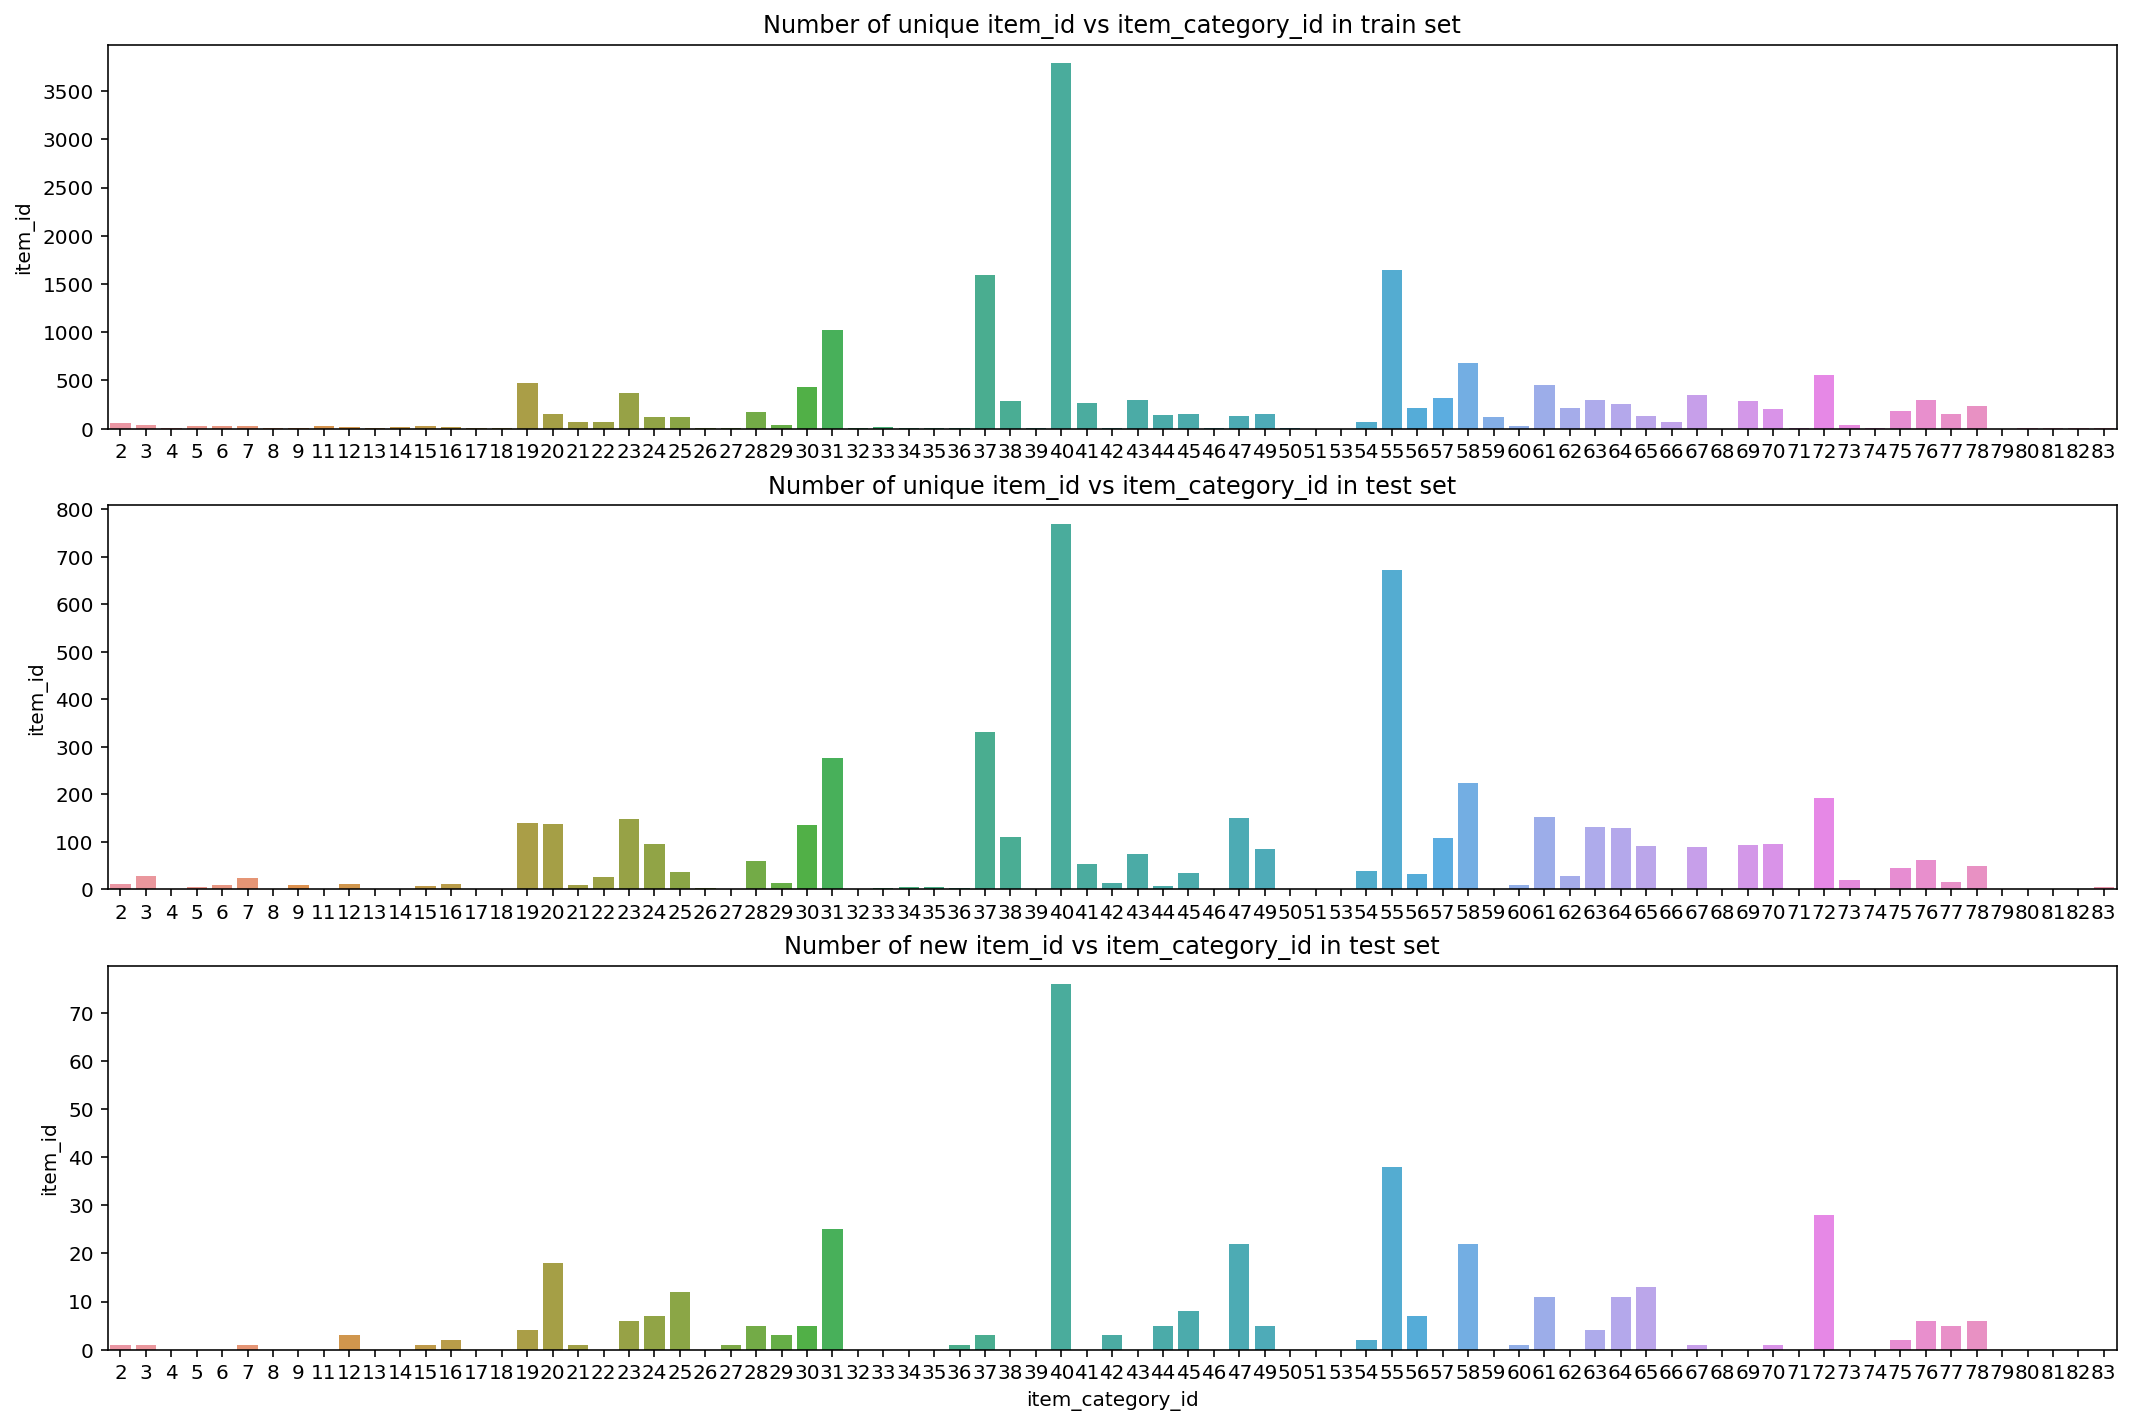

In [232]:
plt.figure(figsize = (18,12));

plt.subplot(3,1,1);
ax1 = sns.barplot(y=unique_item_train["item_id"], x=unique_item_train["item_category_id"].values);
#plt.xticks(ticks=np.arange(0,83,2),labels=np.arange(0,83,2) );  
#ax1.set_yscale('log');
plt.title('Number of unique item_id vs item_category_id in train set');

plt.subplot(3,1,2);

ax2 = sns.barplot(y=unique_item_test["item_id"], x=unique_item_test["item_category_id"].values);
#plt.xticks(ticks=np.arange(0,83,2),labels=np.arange(0,83,2) );  
#ax2.set_yscale('log');
plt.title('Number of unique item_id vs item_category_id in test set');

plt.subplot(3,1,3);

ax2 = sns.barplot(y="item_id", x="item_category_id",data = new_item_test );
#plt.xticks(ticks=np.arange(0,83,2),labels=np.arange(0,83,2) );  
#ax2.set_yscale('log');
plt.title('Number of new item_id vs item_category_id in test set');

### Select features for training

In [95]:
col_keep = [
        'date_block_num', 'shop_id', 'item_id', #'shop_item_cnt_month_sum',
        'city_code', 'item_category_id', 'type_code', 'subtype_code',

        'shop_item_cnt_month_sum_lag_1',
        'shop_item_cnt_month_sum_lag_2', 'shop_item_cnt_month_sum_lag_3',
        #'shop_item_cnt_month_sum_lag_6', 'shop_item_cnt_month_sum_lag_12',

        #'company_allitem_cnt_month_ave', 
        'company_allitem_cnt_month_ave_lag_1',
        #'company_item_cnt_month_sum', 
        'company_item_cnt_month_sum_lag_1',
        'company_item_cnt_month_sum_lag_2', 
        'company_item_cnt_month_sum_lag_3',
        # 'company_item_cnt_month_sum_lag_6',
        'company_item_cnt_month_sum_lag_12',
        #'shop_allitem_cnt_month_ave', 
        'shop_allitem_cnt_month_ave_lag_1',
        'shop_allitem_cnt_month_ave_lag_2', 
        'shop_allitem_cnt_month_ave_lag_3',
        # 'shop_allitem_cnt_month_ave_lag_6', 
        # 'shop_allitem_cnt_month_ave_lag_12',

        #'city_item_cnt_month_sum',
        'city_item_cnt_month_sum_lag_1','city_item_cnt_month_sum_lag_2',
        #'company_item_cnt_month_sum_cat_ave',
        'company_item_cnt_month_sum_cat_ave_lag_1',
        'company_item_cnt_month_sum_cat_ave_lag_2',
        #'shop_item_cnt_month_sum_cat_ave',
        'shop_item_cnt_month_sum_cat_ave_lag_1', 
        'shop_item_cnt_month_sum_cat_ave_lag_2',
        #'city_allitem_cnt_month_ave',
        'city_allitem_cnt_month_ave_lag_1', 



        'delta_company_item_price_month_ave_lag',
        #'shop_allitem_transaction_month_sum',
        #'shop_allitem_transaction_month_sum_year_ave',
        #'delta_shop_allitem_transaction_month',
        'delta_shop_allitem_transaction_month_lag_1', 

        #         'company_item_cnt_month_sum_3m_ave',   'company_item_price_month_ave_3m_ave', 
        #         'shop_item_cnt_month_sum_3m_ave',  'shop_item_price_month_ave_3m_ave',
        #         'company_item_cnt_month_sum_6m_ave',  'company_item_price_month_ave_6m_ave', 
        #         'shop_item_cnt_month_sum_6m_ave',      'shop_item_price_month_ave_6m_ave', 

        'month', 'days',

        'shop_item_first_sale_month',
        'company_item_first_sale_month',



        'shop_item_last_sale_diffmonth',
        'city_item_last_sale_diffmonth', 
        'company_item_last_sale_diffmonth', 

        'shop_item_last_sale',
        'city_item_last_sale',
        'company_item_last_sale', 
        'shop_item_last_price',
        'company_item_last_price', 

        'shop_item_been_sold',
        'company_item_been_sold', 'city_item_been_sold',

        #'company_item_price_last_sale',    

        # 'city_item_price_last_sale',
        # 'shop_item_price_last_sale', 


        'diff_shop_item_cnt_last_sale_vs_3m_ave',
        'diff_company_item_cnt_last_sale_vs_3m_ave',
        'diff_shop_item_cnt_last_sale_vs_6m_ave',
        'diff_company_item_cnt_last_sale_vs_6m_ave',
        'diff_shop_item_price_last_sale_vs_3m_ave',
        'diff_company_item_price_last_sale_vs_3m_ave',
        'diff_shop_item_price_last_sale_vs_6m_ave',
        'diff_company_item_price_last_sale_vs_6m_ave',

        'base_line_pred_longterm',
        'base_line_pred_last_sale'
    
]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [96]:
test_item = matrix[matrix.date_block_num == 34].item_id.unique()
tested = pd.DataFrame()
tested['item_id'] = test_item
tested['item_tested'] = 1
tested.head()

item_id  item_tested
0     5037            1
1     5320            1
2     5233            1
3     5232            1
4     5268            1

In [97]:
matrix.date_block_num.unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34])

In [98]:
# if fillter_test_item = 1, filter the train to have only items that are in the test set

fillter_test_item = 1

train_month_upto=33

if fillter_test_item == 1:
    #X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
    X_train = matrix.merge(tested,on = 'item_id',how = 'inner')[col_keep+['shop_item_cnt_month_sum']].fillna(0)
    X_train = X_train[(X_train.date_block_num<train_month_upto)&(X_train.date_block_num>11)]
    
    Y_train = X_train['shop_item_cnt_month_sum']
    X_train = X_train[col_keep]
    
    #X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
    
    X_valid = matrix.merge(tested,on = 'item_id',how = 'inner')[col_keep+['shop_item_cnt_month_sum']].fillna(0) 
    X_valid = X_valid[(X_valid.date_block_num>=train_month_upto)&(X_valid.date_block_num<=33)]
    
    Y_valid = X_valid['shop_item_cnt_month_sum']
    X_valid = X_valid[col_keep]
    
else:
    #X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
    X_train = matrix[(matrix.date_block_num<train_month_upto)&(matrix.date_block_num>11)][col_keep].fillna(0)
    Y_train = matrix[(matrix.date_block_num<train_month_upto)&(matrix.date_block_num>11)]['shop_item_cnt_month_sum'].fillna(0)
    #X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
    X_valid = matrix[(matrix.date_block_num>=train_month_upto)&(matrix.date_block_num<=33)][col_keep].fillna(0)
    Y_valid = matrix[(matrix.date_block_num>=train_month_upto)&(matrix.date_block_num<=33)]['shop_item_cnt_month_sum'].fillna(0)

#X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)
X_test = matrix[matrix.date_block_num == 34][col_keep].fillna(0)

print(X_train.shape[0],Y_train.shape[0],X_valid.shape[0],Y_valid.shape[0])

2413552 2413552 175604 175604


In [99]:
[col_keep+['shop_item_cnt_month_sum']]

[['date_block_num',
  'shop_id',
  'item_id',
  'city_code',
  'item_category_id',
  'type_code',
  'subtype_code',
  'shop_item_cnt_month_sum_lag_1',
  'shop_item_cnt_month_sum_lag_2',
  'shop_item_cnt_month_sum_lag_3',
  'company_allitem_cnt_month_ave_lag_1',
  'company_item_cnt_month_sum_lag_1',
  'company_item_cnt_month_sum_lag_2',
  'company_item_cnt_month_sum_lag_3',
  'company_item_cnt_month_sum_lag_12',
  'shop_allitem_cnt_month_ave_lag_1',
  'shop_allitem_cnt_month_ave_lag_2',
  'shop_allitem_cnt_month_ave_lag_3',
  'city_item_cnt_month_sum_lag_1',
  'city_item_cnt_month_sum_lag_2',
  'company_item_cnt_month_sum_cat_ave_lag_1',
  'company_item_cnt_month_sum_cat_ave_lag_2',
  'shop_item_cnt_month_sum_cat_ave_lag_1',
  'shop_item_cnt_month_sum_cat_ave_lag_2',
  'city_allitem_cnt_month_ave_lag_1',
  'delta_company_item_price_month_ave_lag',
  'delta_shop_allitem_transaction_month_lag_1',
  'month',
  'days',
  'shop_item_first_sale_month',
  'company_item_first_sale_month',
  'sh

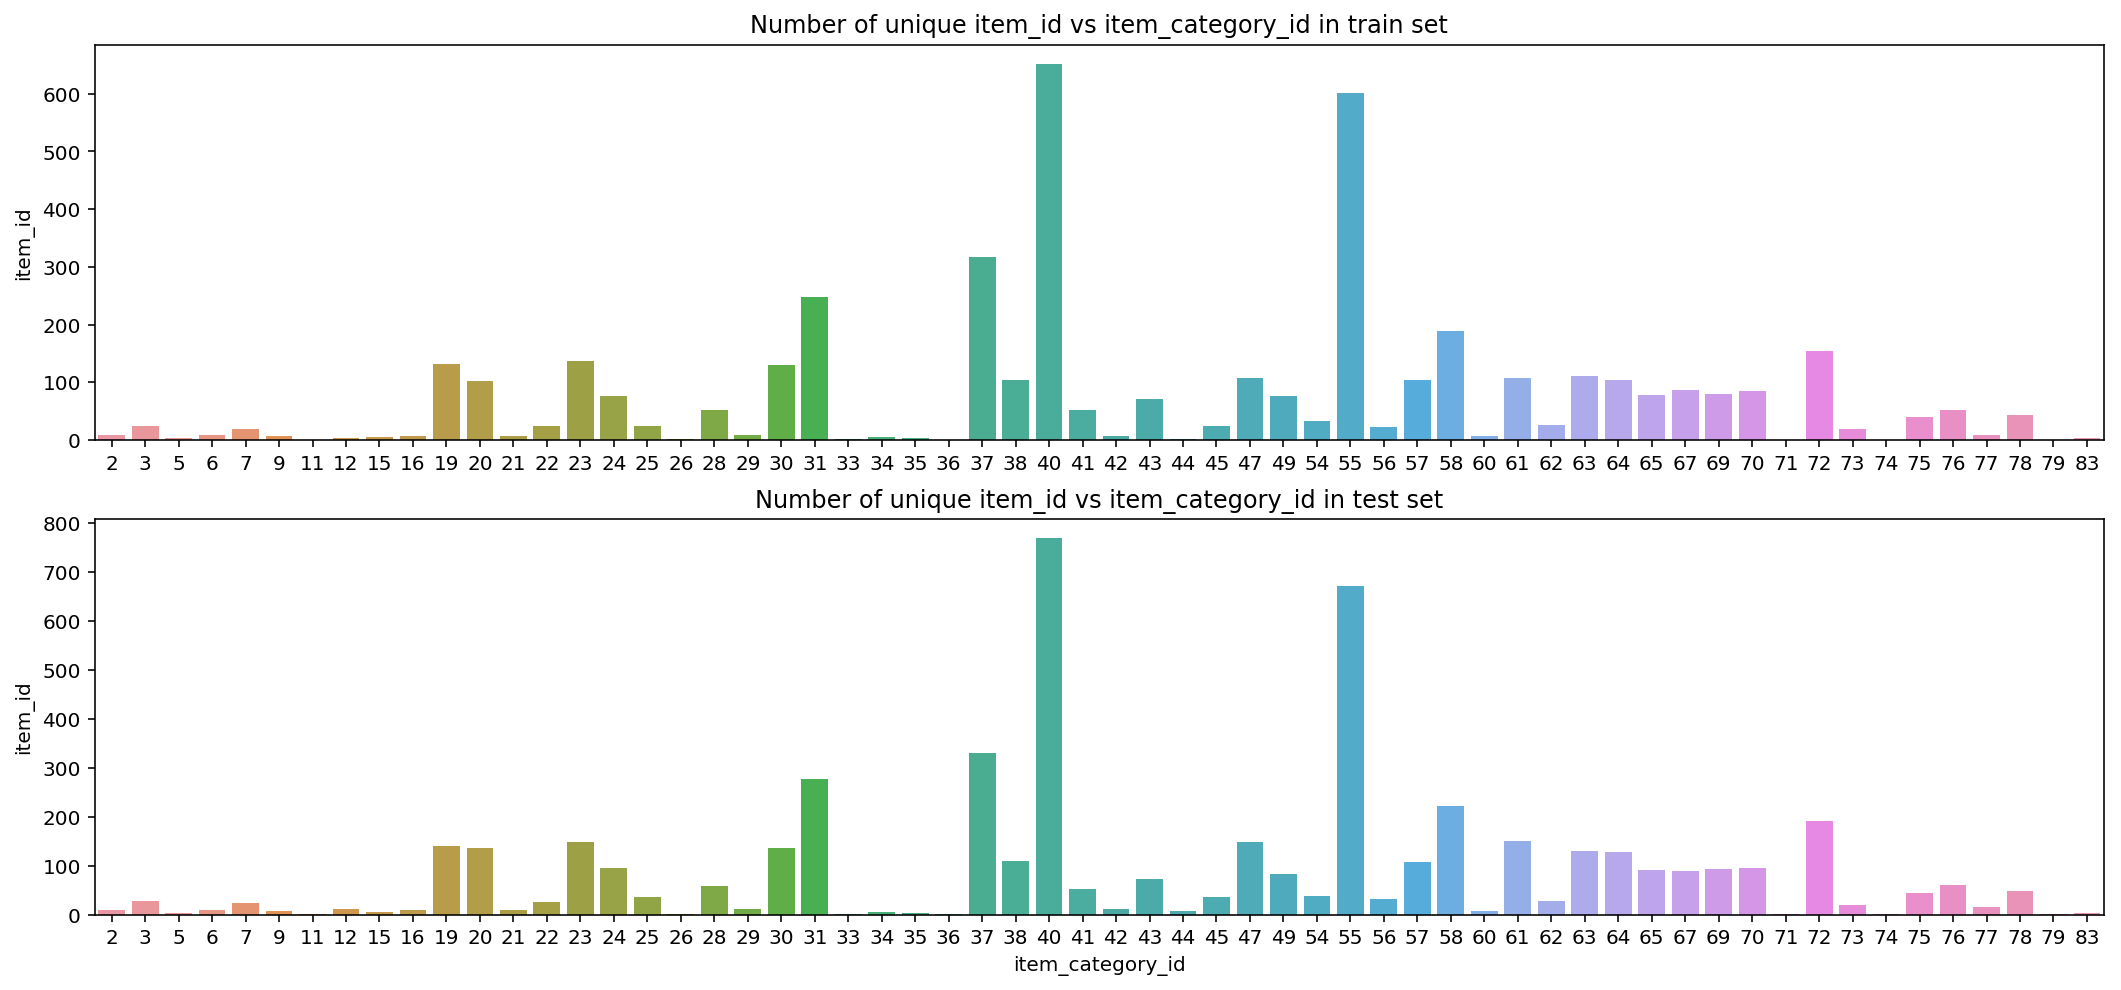

In [191]:
unique_item_train = X_train.groupby("item_category_id")[["item_id"]].nunique().reset_index()

unique_item_test = X_test.groupby("item_category_id")[["item_id"]].nunique().reset_index()

unique_item_test = unique_item_train[["item_category_id"]].merge(unique_item_test,on='item_category_id',how = 'left')


new_unique_item_test = 

plt.figure(figsize = (18,8));

plt.subplot(3,1,1);
ax1 = sns.barplot(y=unique_item_train["item_id"], x=unique_item_train["item_category_id"].values);
#plt.xticks(ticks=np.arange(0,83,2),labels=np.arange(0,83,2) );  
#ax1.set_yscale('log');
plt.title('Number of unique item_id vs item_category_id in train set');

plt.subplot(3,1,2);

ax2 = sns.barplot(y="item_id", x="item_category_id",data = unique_item_test );
#plt.xticks(ticks=np.arange(0,83,2),labels=np.arange(0,83,2) );  
#ax2.set_yscale('log');
plt.title('Number of unique item_id vs item_category_id in test set');

In [102]:
X_train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'city_code', 'item_category_id',
       'type_code', 'subtype_code', 'shop_item_cnt_month_sum_lag_1',
       'shop_item_cnt_month_sum_lag_2', 'shop_item_cnt_month_sum_lag_3',
       'company_allitem_cnt_month_ave_lag_1',
       'company_item_cnt_month_sum_lag_1', 'company_item_cnt_month_sum_lag_2',
       'company_item_cnt_month_sum_lag_3', 'company_item_cnt_month_sum_lag_12',
       'shop_allitem_cnt_month_ave_lag_1', 'shop_allitem_cnt_month_ave_lag_2',
       'shop_allitem_cnt_month_ave_lag_3', 'city_item_cnt_month_sum_lag_1',
       'city_item_cnt_month_sum_lag_2',
       'company_item_cnt_month_sum_cat_ave_lag_1',
       'company_item_cnt_month_sum_cat_ave_lag_2',
       'shop_item_cnt_month_sum_cat_ave_lag_1',
       'shop_item_cnt_month_sum_cat_ave_lag_2',
       'city_allitem_cnt_month_ave_lag_1',
       'delta_company_item_price_month_ave_lag',
       'delta_shop_allitem_transaction_month_lag_1', 'month', 'days',
       'shop_item_

In [103]:
X_valid.head()

date_block_num  shop_id  item_id  city_code  item_category_id  type_code  \
995              33        2       30          0                40         11   
996              33        3       30          1                40         11   
997              33        4       30          2                40         11   
998              33        5       30          3                40         11   
999              33        6       30          4                40         11   

     subtype_code  shop_item_cnt_month_sum_lag_1  \
995             4                            0.0   
996             4                            0.0   
997             4                            0.0   
998             4                            0.0   
999             4                            1.0   

     shop_item_cnt_month_sum_lag_2  shop_item_cnt_month_sum_lag_3  \
995                            0.0                            0.0   
996                            0.0                            1.0   
997                            0.0                            0.0   
998                            1.0                            0.0   
999                            0.0                            0.0   

     company_allitem_cnt_month_ave_lag_1  company_item_cnt_month_sum_lag_1  \
995                             0.263672                          0.069763   
996                             0.263672                          0.069763   
997                             0.263672                          0.069763   
998                             0.263672                          0.069763   
999                             0.263672                          0.069763   

     company_item_cnt_month_sum_lag_2  company_item_cnt_month_sum_lag_3  \
995                          0.142822                          0.093018   
996                          0.142822                          0.093018   
997                          0.142822                          0.093018   
998                          0.142822                          0.093018   
999                          0.142822                          0.093018   

     company_item_cnt_month_sum_lag_12  shop_allitem_cnt_month_ave_lag_1  \
995                               0.25                          0.157959   
996                               0.25                          0.132568   
997                               0.25                          0.135132   
998                               0.25                          0.205933   
999                               0.25                          0.314941   

     shop_allitem_cnt_month_ave_lag_2  shop_allitem_cnt_month_ave_lag_3  \
995                          0.184448                          0.143311   
996                          0.126465                          0.101074   
997                          0.169922                          0.152588   
998                          0.245117                          0.179810   
999                          0.300537                          0.270996   

     city_item_cnt_month_sum_lag_1  city_item_cnt_month_sum_lag_2  \
995                            0.0                            0.0   
996                            0.0                            0.0   
997                            0.0                            0.0   
998                            0.0                            1.0   
999                            0.5                            0.0   

     company_item_cnt_month_sum_cat_ave_lag_1  \
995                                  0.200928   
996                                  0.200928   
997                                  0.200928   
998                                  0.200928   
999                                  0.200928   

     company_item_cnt_month_sum_cat_ave_lag_2  \
995                                  0.242188   
996                                  0.242188   
997                                  0.242188   
998                                  0.242188   
999    

* ### XGBoost

In [104]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=50,
    min_child_weight=300, 
    colsample_bytree=0.7, 
    subsample=0.7, 
    eta=0.3,    
    seed=42)

# model.fit(
#     X_train, 
#     Y_train, 
#     eval_metric="rmse", 
#     eval_set=[(X_train_0, Y_train_0), (X_valid_0, Y_valid_0)], 
#     verbose=True, 
#     early_stopping_rounds = 10)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)


time.time() - ts

[0]	validation_0-rmse:1.51093	validation_1-rmse:1.25197
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.42016	validation_1-rmse:1.19455
[2]	validation_0-rmse:1.33997	validation_1-rmse:1.14327
[3]	validation_0-rmse:1.2712	validation_1-rmse:1.10066
[4]	validation_0-rmse:1.20879	validation_1-rmse:1.06106
[5]	validation_0-rmse:1.15794	validation_1-rmse:1.02827
[6]	validation_0-rmse:1.1125	validation_1-rmse:1.00056
[7]	validation_0-rmse:1.07115	validation_1-rmse:0.975357
[8]	validation_0-rmse:1.03749	validation_1-rmse:0.955702
[9]	validation_0-rmse:1.00842	validation_1-rmse:0.938709
[10]	validation_0-rmse:0.98407	validation_1-rmse:0.923829
[11]	validation_0-rmse:0.962099	validation_1-rmse:0.910514
[12]	validation_0-rmse:0.944174	validation_1-rmse:0.899938
[13]	validation_0-rmse:0.928476	validation_1-rmse:0.891187
[14]	validation_0-rmse:0.914422	validation_1-

918.818382024765

prepare the predicted result for comparison with the actual sale data

In [121]:
# 

Y_pred = model.predict(X_valid).clip(0, 20)

YY = pd.DataFrame()
YY['Y_pred'] = Y_pred
YY['Y_valid'] = Y_valid.values

YY['date_block_num'] = X_valid['date_block_num'].reset_index().drop('index',axis=1)
YY['shop_id'] = X_valid['shop_id'].reset_index().drop('index',axis=1)
YY['item_id'] = X_valid['item_id'].reset_index().drop('index',axis=1)
YY['item_category_id'] = X_valid['item_category_id'].reset_index().drop('index',axis=1)
YY


# Y_pred = model.predict(X_valid_0).clip(0, 20)


# YY = pd.DataFrame()
# YY['Y_pred'] = Y_pred
# YY['Y_valid'] = Y_valid_0.values

# YY['date_block_num'] = X_valid_0['date_block_num'].reset_index().drop('index',axis=1)
# YY['shop_id'] = X_valid_0['shop_id'].reset_index().drop('index',axis=1)
# YY['item_id'] = X_valid_0['item_id'].reset_index().drop('index',axis=1)
# YY['item_category_id'] = X_valid_0['item_category_id'].reset_index().drop('index',axis=1)
# YY.head()

Y_pred  Y_valid  date_block_num  shop_id  item_id  item_category_id
0       0.028688      0.0              33        2       30                40
1       0.036350      0.0              33        3       30                40
2       0.019333      0.0              33        4       30                40
3       0.071946      0.0              33        5       30                40
4       0.056343      0.0              33        6       30                40
5       0.019793      0.0              33        7       30                40
6       0.014994      0.0              33        9       30                40
7       0.012685      0.0              33       11       30                40
8       0.002811      0.0              33       12       30                40
9       0.057838      0.0              33       14       30                40
10      0.046552      0.0              33       15       30                40
11      0.037167      0.0              33       16       30                40
12      0.018108      0.0              33       18       30                40
13      0.057539      0.0              33       19       30                40
14      0.006143      0.0              33       20       30                40
15      0.132948      0.0              33       21       30                40
16      0.082422      0.0              33       22       30                40
17      0.076067      0.0              33       24       30                40
18      0.252524      0.0              33       25       30                40
19      0.138920      0.0              33       26       30                40
20      0.157713      0.0              33       28       30                40
21      0.245509      1.0              33       31       30                40
22      0.000377      0.0              33       34       30                40
23      0.030131      0.0              33       35       30                40
24      0.086314      0.0              33       36       30                40
25      0.021313      0.0              33       37       30                40
26      0.037938      0.0              33       38       30                40
27      0.003516      0.0              33       39       30                40
28      0.008048      0.0              33       41       30                40
29      0.136845      0.0              33       42       30                40
30      0.018280      0.0              33       44       30                40
31      0.010713      0.0              33       45       30                40
32      0.098680      0.0              33       46       30                40
33      0.023689      0.0              33       47       30                40
34      0.037938      0.0              33       48       30                40
35      0.007497      0.0              33       49       30                40
36      0.016767      0.0              33       50       30                40
37      0.019911      0.0              33       52       30                40
38      0.026408      0.0              33       53       30                40
39      0.001763      0.0              33       55       30                40
40      0.124881      0.0              33       56       30                40
41      0.112976      0.0              33       57       30                40
42      0.061271      0.0              33       58       30                40
43      0.029225      0.0              33       59       30                40
44      0.079719      1.0              33        2       31                37
45      0.067881      0.0              33        3       31                37
46      0.185808      0.0              33        4       31                37
47      0.275343      0.0              33        5       31                37
48      0.364186      2.0              33        6       31                37
49      0.743868      0.0              33        7       31                37
50      0.189609      0.0       

In [126]:
Y_fit =  model.predict(X_train).clip(0, 20)


YY_0 = pd.DataFrame()
YY_0['Y_pred'] = Y_fit
YY_0['Y_valid'] = Y_train.values

YY_0['date_block_num'] = X_train['date_block_num'].reset_index().drop('index',axis=1)
YY_0['shop_id'] = X_train['shop_id'].reset_index().drop('index',axis=1)
YY_0['item_id'] = X_train['item_id'].reset_index().drop('index',axis=1)
YY_0['item_category_id'] = X_train['item_category_id'].reset_index().drop('index',axis=1)
YY_0

# Y_fit =  model.predict(X_train_0).clip(0, 20)


# YY_0 = pd.DataFrame()
# YY_0['Y_pred'] = Y_fit
# YY_0['Y_valid'] = Y_train_0.values

# YY_0['date_block_num'] = X_train_0['date_block_num'].reset_index().drop('index',axis=1)
# YY_0['shop_id'] = X_train_0['shop_id'].reset_index().drop('index',axis=1)
# YY_0['item_id'] = X_train_0['item_id'].reset_index().drop('index',axis=1)
# YY_0['item_category_id'] = X_train_0['item_category_id'].reset_index().drop('index',axis=1)
# YY_0.head()


Y_pred  Y_valid  date_block_num  shop_id  item_id  item_category_id
0        0.102179      0.0              12        2       30                40
1        0.569161      1.0              12        3       30                40
2        0.505426      0.0              12        4       30                40
3        0.580714      1.0              12        5       30                40
4        1.028212      1.0              12        6       30                40
5        1.720876      4.0              12        7       30                40
6        0.412418      0.0              12       11       30                40
7        0.383074      0.0              12       12       30                40
8        0.609590      0.0              12       13       30                40
9        0.439425      0.0              12       14       30                40
10       1.185369      1.0              12       15       30                40
11       0.711434      1.0              12       16       30                40
12       0.538960      1.0              12       17       30                40
13       0.426558      0.0              12       18       30                40
14       0.958951      1.0              12       19       30                40
15       0.757040      1.0              12       21       30                40
16       0.587874      1.0              12       22       30                40
17       0.940844      1.0              12       24       30                40
18       4.919695     10.0              12       25       30                40
19       1.309487      1.0              12       26       30                40
20       2.161078      5.0              12       27       30                40
21       3.167559      4.0              12       28       30                40
22       1.176482      0.0              12       29       30                40
23       1.298106      1.0              12       30       30                40
24       6.133782      7.0              12       31       30                40
25       0.687267      1.0              12       35       30                40
26       0.495644      0.0              12       37       30                40
27       0.575710      0.0              12       38       30                40
28       0.748568      2.0              12       41       30                40
29       1.269262      4.0              12       42       30                40
30       1.316326      0.0              12       43       30                40
31       0.670998      0.0              12       44       30                40
32       0.588522      1.0              12       45       30                40
33       0.971721      1.0              12       46       30                40
34       0.602969      0.0              12       47       30                40
35       0.547671      0.0              12       49       30                40
36       1.283602      1.0              12       50       30                40
37       0.776303      0.0              12       51       30                40
38       0.557523      1.0              12       52       30                40
39       0.893035      1.0              12       53       30                40
40       2.755382      3.0              12       54       30                40
41       0.286252      0.0              12       55       30                40
42       0.910777      0.0              12       56       30                40
43       1.963877      1.0              12       57       30                40
44       1.426927      0.0              12       58       30                40
45       0.544166      0.0              12       59       30                40
46       0.222606      0.0              13        2       30                40
47       0.316103      0.0              13        3       30                40
48       0.133709      0.0              13        4       30                40
49       0.355190      0.0              13        5       30 

In [123]:
Y_test_pred = model.predict(X_test).clip(0, 20)

YY_1 = pd.DataFrame()

YY_1['Y_pred'] = Y_test_pred
YY_1['Y_valid'] = np.nan

YY_1['date_block_num'] = X_test['date_block_num'].reset_index().drop('index',axis=1)
YY_1['shop_id'] = X_test['shop_id'].reset_index().drop('index',axis=1)
YY_1['item_id'] = X_test['item_id'].reset_index().drop('index',axis=1)
YY_1['item_category_id'] = X_test['item_category_id'].reset_index().drop('index',axis=1)
YY_1.head()

Y_pred  Y_valid  date_block_num  shop_id  item_id  item_category_id
0  0.681873      NaN              34        5     5037                19
1  0.151248      NaN              34        5     5320                55
2  0.928471      NaN              34        5     5233                19
3  0.351945      NaN              34        5     5232                23
4  2.045692      NaN              34        5     5268                20

In [127]:
YY_0 = pd.concat([YY_0,YY], ignore_index=True)
YY_0 = pd.concat([YY_0,YY_1], ignore_index=True)
YY_0

Y_pred  Y_valid  date_block_num  shop_id  item_id  item_category_id
0        0.102179      0.0              12        2       30                40
1        0.569161      1.0              12        3       30                40
2        0.505426      0.0              12        4       30                40
3        0.580714      1.0              12        5       30                40
4        1.028212      1.0              12        6       30                40
5        1.720876      4.0              12        7       30                40
6        0.412418      0.0              12       11       30                40
7        0.383074      0.0              12       12       30                40
8        0.609590      0.0              12       13       30                40
9        0.439425      0.0              12       14       30                40
10       1.185369      1.0              12       15       30                40
11       0.711434      1.0              12       16       30                40
12       0.538960      1.0              12       17       30                40
13       0.426558      0.0              12       18       30                40
14       0.958951      1.0              12       19       30                40
15       0.757040      1.0              12       21       30                40
16       0.587874      1.0              12       22       30                40
17       0.940844      1.0              12       24       30                40
18       4.919695     10.0              12       25       30                40
19       1.309487      1.0              12       26       30                40
20       2.161078      5.0              12       27       30                40
21       3.167559      4.0              12       28       30                40
22       1.176482      0.0              12       29       30                40
23       1.298106      1.0              12       30       30                40
24       6.133782      7.0              12       31       30                40
25       0.687267      1.0              12       35       30                40
26       0.495644      0.0              12       37       30                40
27       0.575710      0.0              12       38       30                40
28       0.748568      2.0              12       41       30                40
29       1.269262      4.0              12       42       30                40
30       1.316326      0.0              12       43       30                40
31       0.670998      0.0              12       44       30                40
32       0.588522      1.0              12       45       30                40
33       0.971721      1.0              12       46       30                40
34       0.602969      0.0              12       47       30                40
35       0.547671      0.0              12       49       30                40
36       1.283602      1.0              12       50       30                40
37       0.776303      0.0              12       51       30                40
38       0.557523      1.0              12       52       30                40
39       0.893035      1.0              12       53       30                40
40       2.755382      3.0              12       54       30                40
41       0.286252      0.0              12       55       30                40
42       0.910777      0.0              12       56       30                40
43       1.963877      1.0              12       57       30                40
44       1.426927      0.0              12       58       30                40
45       0.544166      0.0              12       59       30                40
46       0.222606      0.0              13        2       30                40
47       0.316103      0.0              13        3       30                40
48       0.133709      0.0              13        4       30                40
49       0.355190      0.0              13        5       30 

Plot the predicted total sale of different shops over months

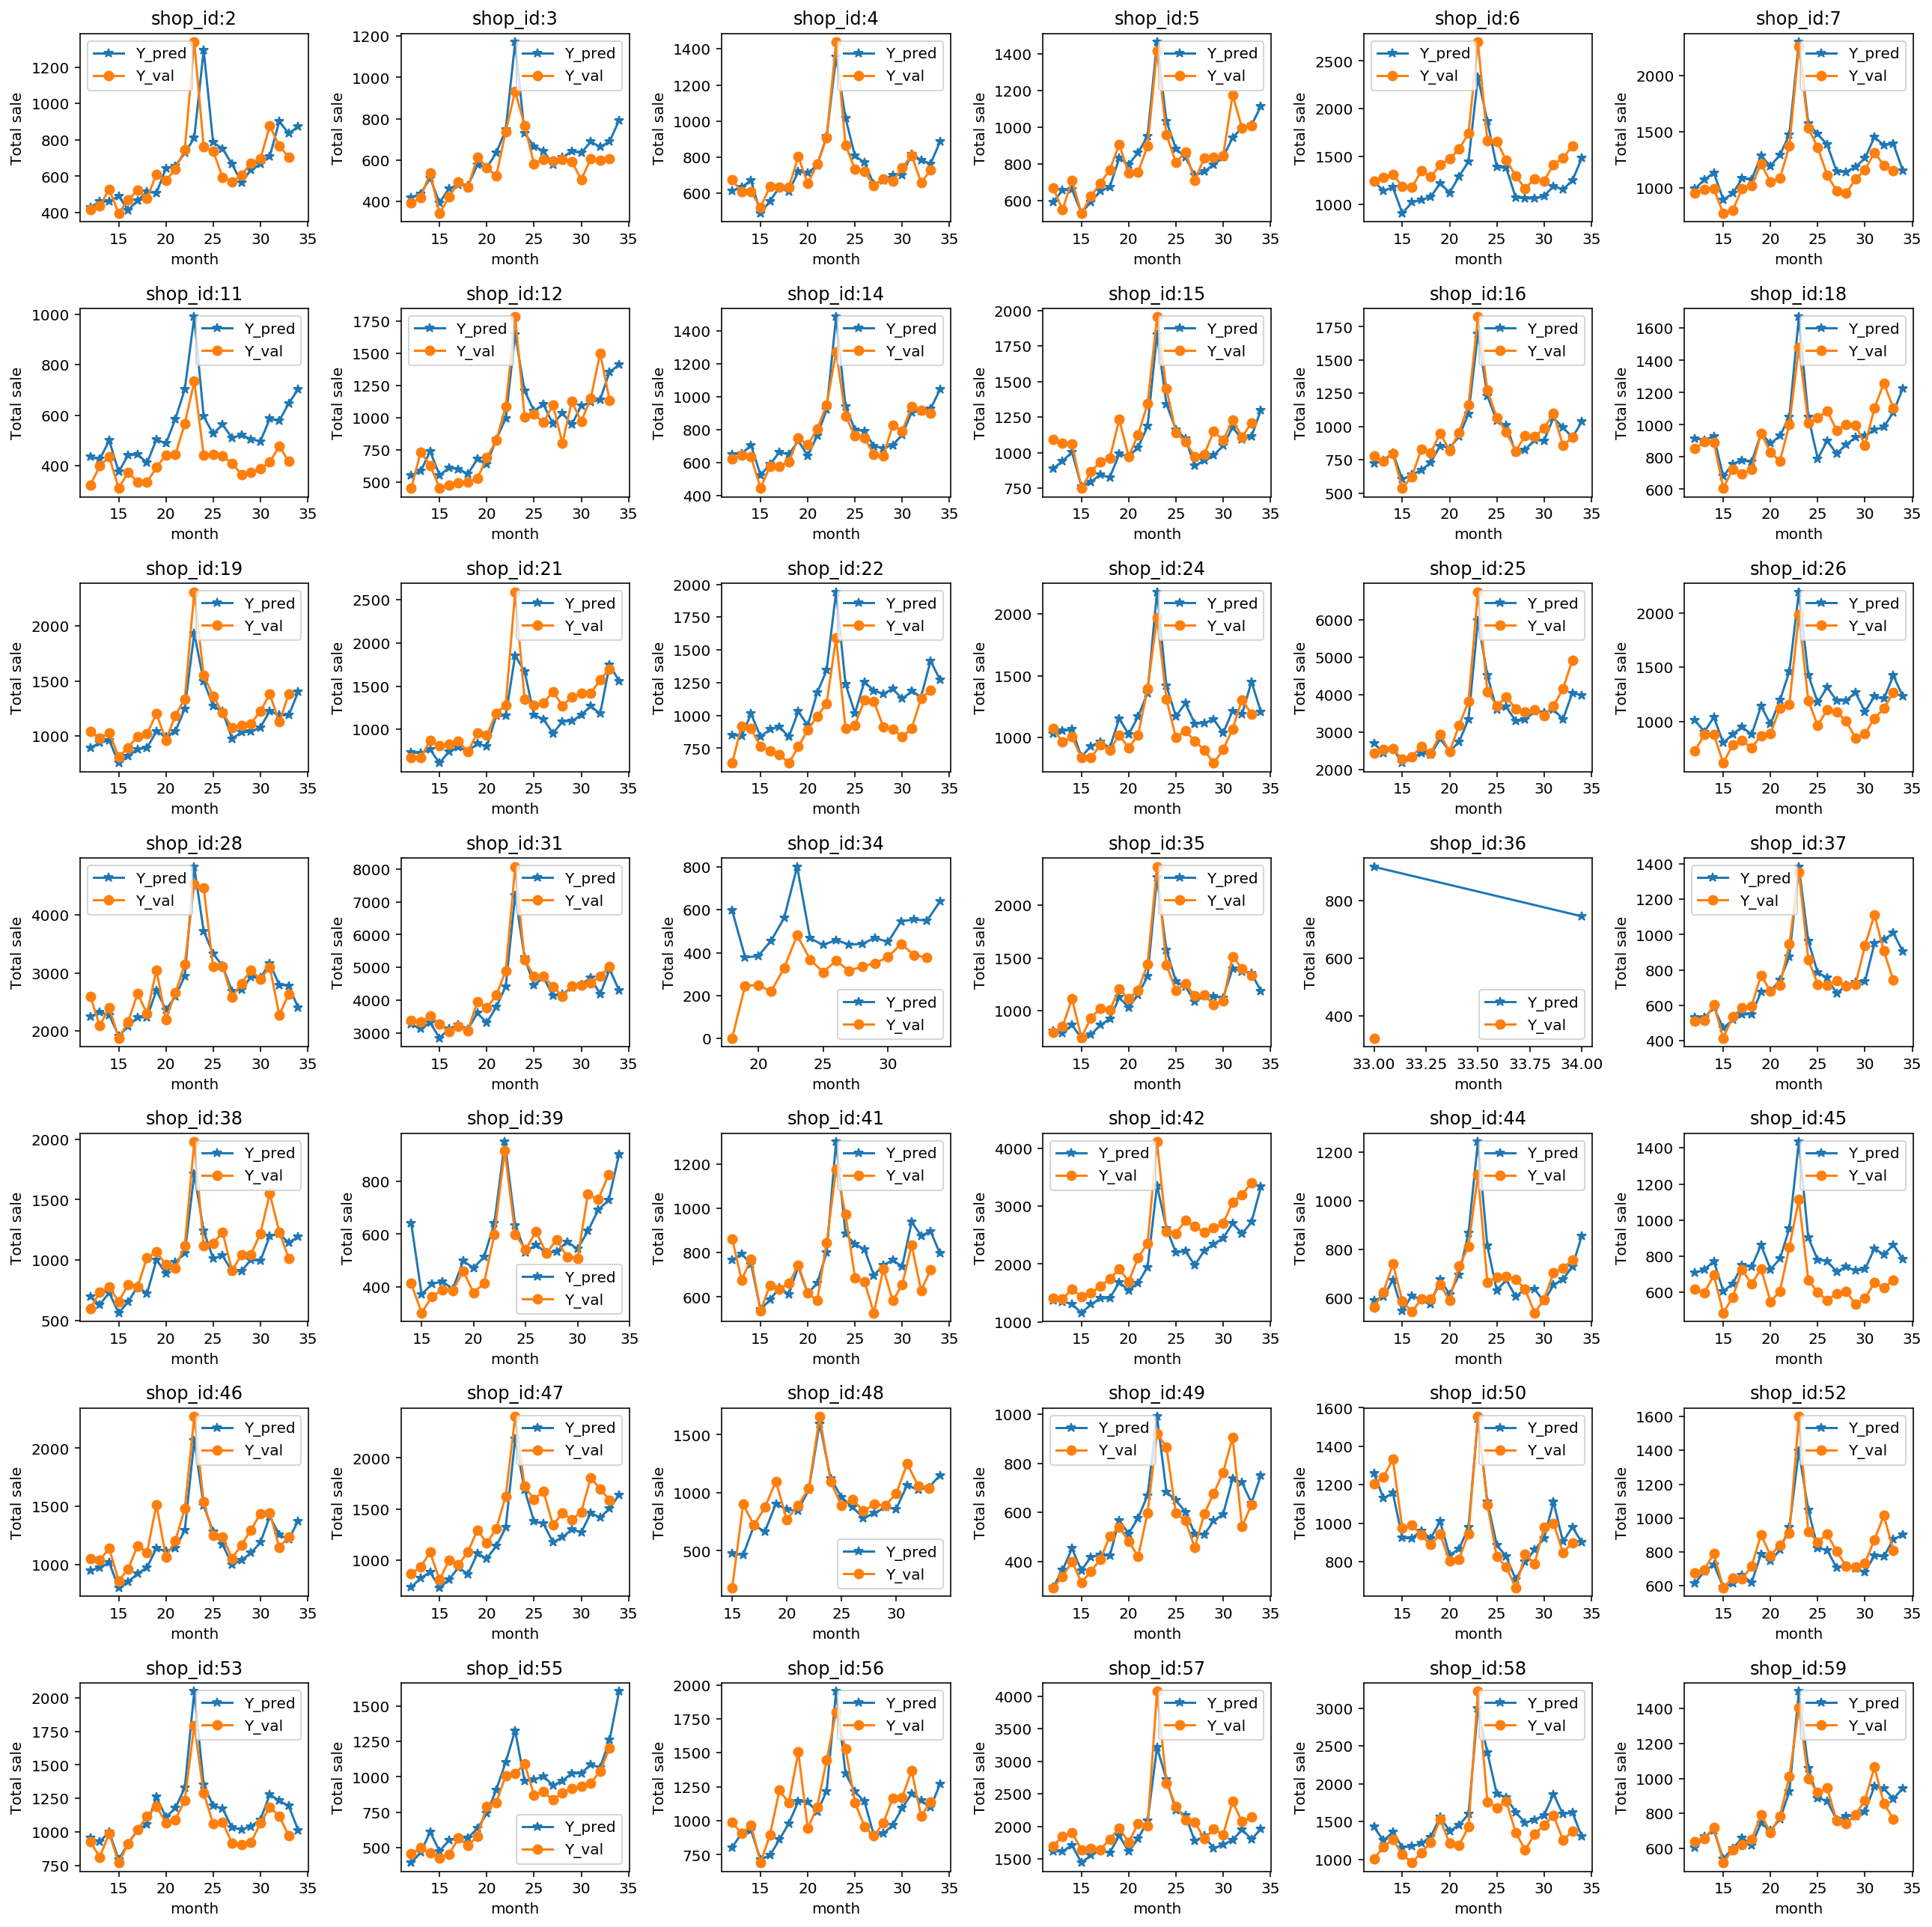

In [183]:
# Plot the predicted total sale of different shops over months

check_shop = X_test.shop_id.unique()
check_shop = np.sort(check_shop)
num_check_shop = X_test.shop_id.nunique()

fignum = np.round(np.sqrt(num_check_shop))

j=1
plt.figure(figsize=(18,18));

for i in check_shop:
    
    check_shop_id = i

    total_sale_pred = YY_0[YY_0.shop_id==check_shop_id].groupby('date_block_num')['Y_pred'].sum();
    total_sale_val = YY_0[YY_0.shop_id==check_shop_id].groupby('date_block_num')['Y_valid'].sum();

    plt.subplot(7,6,j);
    plt.plot(total_sale_pred,'*-');
    plt.plot(total_sale_val[0:-1],'o-');
    plt.legend(['Y_pred','Y_val']);
    plt.title('shop_id:'+ str(i));
    plt.xlabel('month');
    plt.ylabel('Total sale');
    j+=1
    
plt.tight_layout()

Plot the predicted sale of different items over months

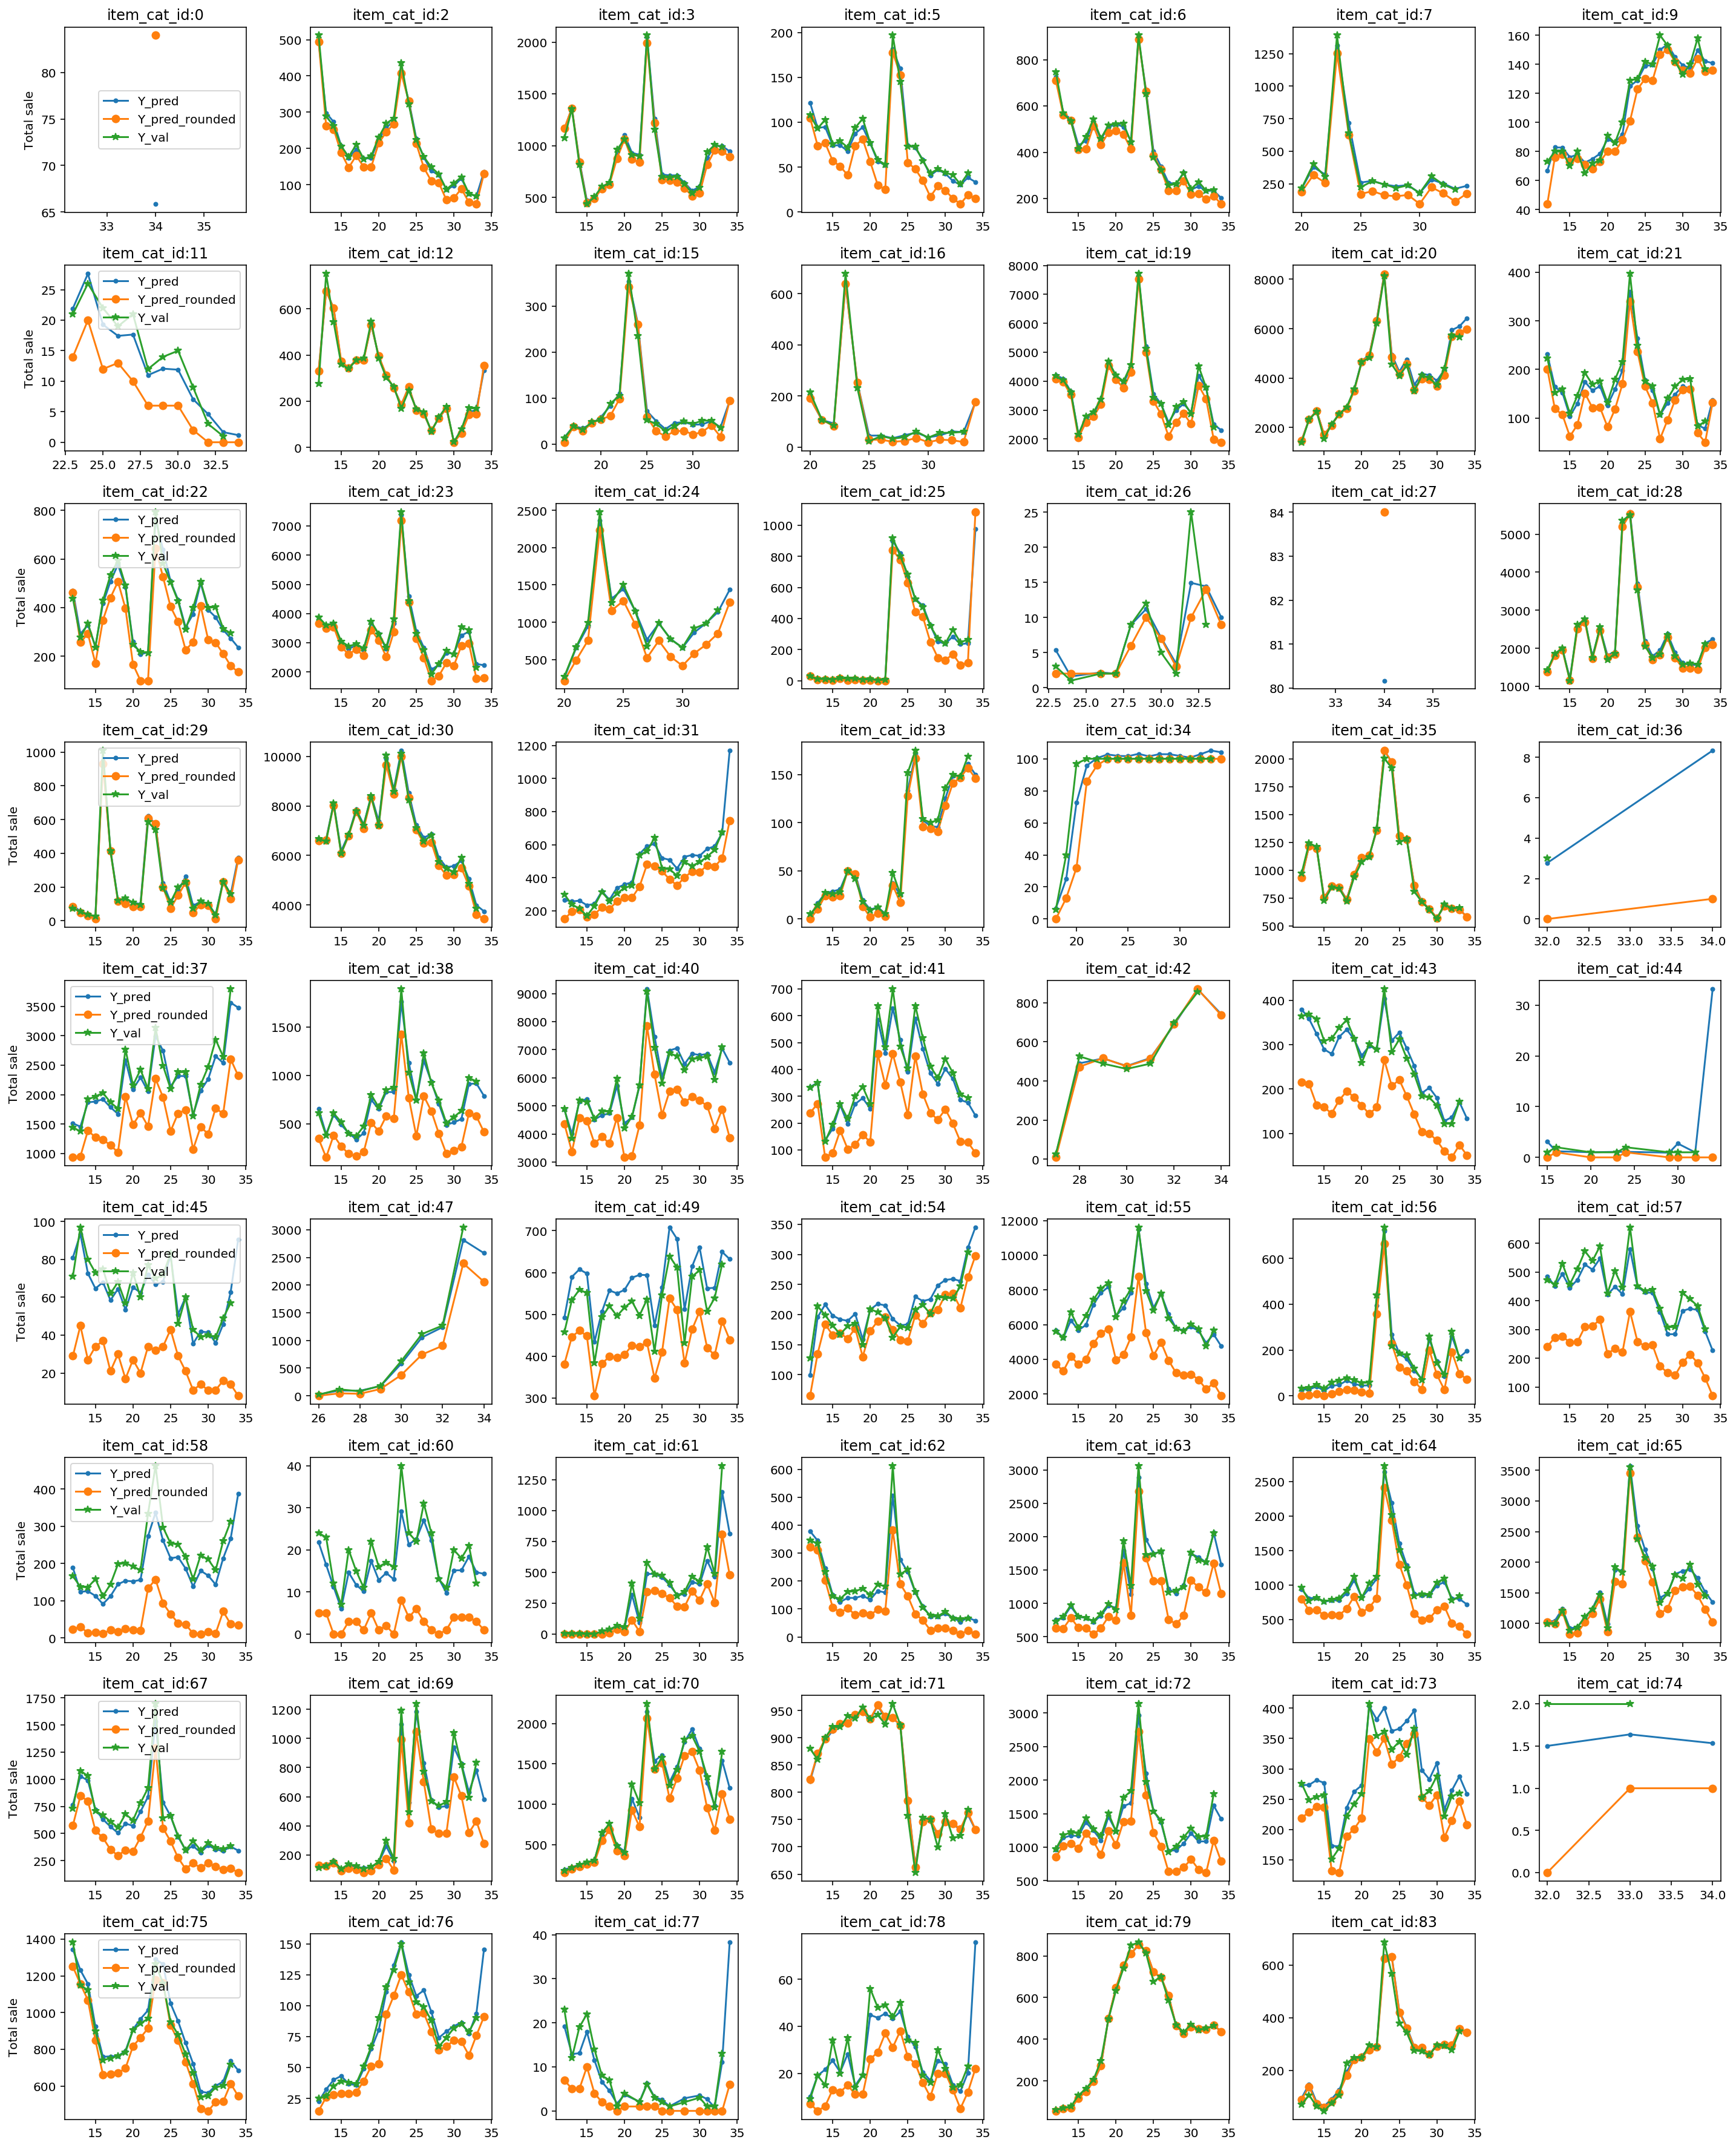

In [184]:
# Plot the predicted total sale of different items over months

check_item_category = YY_0.item_category_id.unique()
check_item_category = np.sort(check_item_category)
num_check_item_category = YY_0.item_category_id.nunique()

fignum = np.round(np.sqrt(num_check_item_category))

YY_0['Y_pred_round'] = np.round(YY_0['Y_pred'])

j=1
plt.figure(figsize=(20,30));

for i in check_item_category:
    
    
    total_sale_pred = YY_0[YY_0.item_category_id==i].groupby('date_block_num')['Y_pred'].sum();
    total_sale_pred_round = YY_0[YY_0.item_category_id==i].groupby('date_block_num')['Y_pred_round'].sum();
    
    total_sale_val = YY_0[YY_0.item_category_id==i].groupby('date_block_num')['Y_valid'].sum();

    plt.subplot(11,7,j);
    plt.plot(total_sale_pred,'.-');
    plt.plot(total_sale_pred_round,'o-');
    plt.plot(total_sale_val[0:-1],'*-');
    
    plt.title('item_cat_id:'+ str(i));
    #plt.xlabel('month');
    
    if j%7 == 1:
        plt.ylabel('Total sale');
        plt.legend(['Y_pred','Y_pred_rounded','Y_true']);
        
    j+=1
    
plt.tight_layout()

The predicted results (Y_pred) for the training months (date_block_num <33) and the validation month (date_block_num = 33) match reasonably well with the true values (Y_val). Using rounded results seem to enlarge the error.

In [133]:
del YY0
gc.collect()

163848

In [134]:
# calculate the RMSE of each item_cat
from sklearn.metrics import mean_squared_error

RMSE_item_cat = pd.DataFrame()

j=1

for i in check_item_category:
    
    
    train_pred = YY_0[(YY_0.item_category_id==i) & (YY_0.date_block_num<train_month_upto)]['Y_pred'];
    train_pred_r = YY_0[(YY_0.item_category_id==i) & (YY_0.date_block_num<train_month_upto)]['Y_pred_round'];
    train_true = YY_0[(YY_0.item_category_id==i) & (YY_0.date_block_num<train_month_upto)]['Y_valid'];
    
    val_pred = YY_0[(YY_0.item_category_id==i) & (YY_0.date_block_num>=train_month_upto) & (YY_0.date_block_num<=33)]['Y_pred'];
    val_pred_r = YY_0[(YY_0.item_category_id==i) & (YY_0.date_block_num>=train_month_upto)& (YY_0.date_block_num<=33)]['Y_pred_round'];
    val_true = YY_0[(YY_0.item_category_id==i) & (YY_0.date_block_num>=train_month_upto)& (YY_0.date_block_num<=33)]['Y_valid'];
    
    
    ### rmse for train and train_round
    if train_pred.shape[0]!=0:
        rmse_train = np.sqrt(mean_squared_error(train_pred, train_true));
    
    else:
        rmse_train = 0
        
    if train_pred.shape[0]!=0:
        rmse_train_r = np.sqrt(mean_squared_error(train_pred_r, train_true));
    
    else:
        rmse_train_r = 0
    
    ### rmse for validation and validation_round
    if val_pred.shape[0]!=0:
        rmse_val = np.sqrt(mean_squared_error(val_pred, val_true));
        
    else:
        rmse_val = 0
        
    if val_pred.shape[0]!=0:
        rmse_val_r = np.sqrt(mean_squared_error(val_pred_r, val_true));
        
    else:
        rmse_val_r = 0
    
    
    RMSE_item_cat.loc[j-1,'item_category_id'] = np.int(i);
    RMSE_item_cat.loc[j-1,'rmse_train'] = rmse_train;
    RMSE_item_cat.loc[j-1,'rmse_val'] = rmse_val;
    
    RMSE_item_cat.loc[j-1,'rmse_train_round'] = rmse_train_r;
    RMSE_item_cat.loc[j-1,'rmse_val_round'] = rmse_val_r;
    
    j+=1
    
RMSE_item_cat['item_category_id'] =RMSE_item_cat['item_category_id'].astype(np.int8);
RMSE_item_cat

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/opt/conda/lib/python3.6/site-pack

item_category_id  rmse_train  rmse_val  rmse_train_round  rmse_val_round
0                  0    0.000000  0.000000          0.000000        0.000000
1                  2    0.847371  0.425707          0.882952        0.441367
2                  3    1.217511  0.962221          1.241023        0.997050
3                  5    0.663164  0.432778          0.717512        0.476731
4                  6    1.163501  0.776793          1.195159        0.827441
5                  7    0.832246  0.452708          0.861187        0.500000
6                  9    0.538839  0.425721          0.543118        0.439525
7                 11    0.572066  0.155571          0.637647        0.150756
8                 12    2.846666  0.727767          2.866827        0.761279
9                 15    1.054473  0.390711          1.069381        0.445941
10                16    1.310115  0.424799          1.339924        0.476731
11                19    1.103789  0.700998          1.134462        0.737082
12                20    1.665315  1.634642          1.690266        1.660186
13                21    0.669738  0.633730          0.716372        0.704423
14                22    0.689306  0.506508          0.735206        0.551032
15                23    1.011211  0.676301          1.044233        0.723612
16                24    0.785300  0.844703          0.820463        0.869506
17                25    0.870749  0.518479          0.911377        0.569090
18                26    0.580056  0.491655          0.576356        0.533002
19                27    0.000000  0.000000          0.000000        0.000000
20                28    1.547947  1.311445          1.566591        1.323789
21                29    1.485784  1.464254          1.508667        1.453835
22                30    1.517807  1.105265          1.541569        1.135785
23                31    0.393678  0.489863          0.397139        0.488198
24                33    1.204286  1.690373          1.227657        1.705606
25                34    0.694093  0.078780          0.698204        0.000000
26                35    2.543821  2.152107          2.562044        2.195036
27                36    0.452658  0.000000          0.457496        0.000000
28                37    0.595267  0.769947          0.624358        0.802887
29                38    0.537078  0.554533          0.565863        0.583658
30                40    0.752636  0.596788          0.780703        0.625870
31                41    0.533273  0.519096          0.566289        0.535901
32                42    2.045842  3.308709          2.064456        3.324610
33                43    0.311991  0.244800          0.335052        0.246183
34                44    0.133498  0.000000          0.145671        0.000000
35                45    0.261737  0.205304          0.284332        0.227098
36                47    0.705045  1.588486          0.729939        1.602838
37                49    0.523706  0.501908          0.538873        0.513006
38                54    0.530764  0.417452          0.534868        0.419891
39                55    0.569799  0.473708          0.612636        0.508870
40                56    0.697883  0.455493          0.722810        0.487892
41                57    0.326068  0.257012          0.350901        0.282648
42                58    0.247870  0.242966          0.264913        0.263909
43                60    0.284443  0.208726          0.310675        0.221906
44                61    0.591690  1.266991          0.614222        1.276739
45                62    0.570448  0.272854          0.595088        0.305257
46                63    0.812966  1.274246          0.848049        1.287010
47                64    0.645273  0.435342          0.682550        0.465600
48                65    1.302411  0.958347          1.324454        0.988733
49                67    0.518605  0.363521          0.549096        0.392527
50                69    0.754901  0.735381          0.780115        0.765532


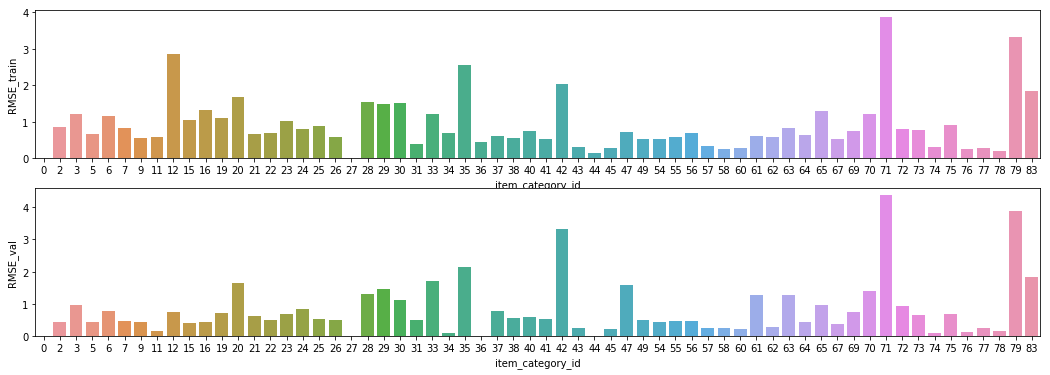

In [135]:
plt.figure(figsize=(18,6));
plt.subplot(2,1,1)
ax = sns.barplot(x="item_category_id", y='rmse_train', data=RMSE_item_cat)

#plt.legend(['train','val']); 
plt.ylabel('RMSE_train'); 

plt.subplot(2,1,2)
bx = sns.barplot(x="item_category_id", y='rmse_val', data=RMSE_item_cat)

plt.ylabel('RMSE_val'); 


It seems strage that the large difference in total sale does not match the RMSE results. For example, item_category_id = 31 has a large total sale difference, but its RMSE is not large at all. While, item_category_id = 71 has the largest RMSE but the total sale difference is definitely not the largest.

In [185]:
YY_0[YY_0.item_category_id == 31]

Y_pred  Y_valid  date_block_num  shop_id  item_id  \
33218    0.201326      0.0              12        2      502   
33219    0.022011      0.0              12        3      502   
33220    0.022011      0.0              12        4      502   
33221    0.022011      0.0              12        5      502   
33222    0.017667      0.0              12        6      502   
33223    0.018531      0.0              12        7      502   
33224    0.022011      0.0              12       11      502   
33225    0.022011      0.0              12       12      502   
33226    0.022011      0.0              12       13      502   
33227    0.022011      0.0              12       14      502   
33228    0.023753      0.0              12       15      502   
33229    0.022011      0.0              12       16      502   
33230    0.022011      0.0              12       17      502   
33231    0.026378      0.0              12       18      502   
33232    0.022889      0.0              12       19      502   
33233    0.018531      0.0              12       21      502   
33234    0.016668      0.0              12       22      502   
33235    0.016668      0.0              12       24      502   
33236    0.021205      0.0              12       25      502   
33237    0.016668      0.0              12       26      502   
33238    0.015804      0.0              12       27      502   
33239    0.015804      0.0              12       28      502   
33240    0.016668      0.0              12       29      502   
33241    0.016668      0.0              12       30      502   
33242    0.021205      0.0              12       31      502   
33243    0.021889      0.0              12       35      502   
33244    0.020148      0.0              12       37      502   
33245    0.020148      0.0              12       38      502   
33246    0.021889      0.0              12       41      502   
33247    0.015804      0.0              12       42      502   
33248    0.016668      0.0              12       43      502   
33249    0.020148      0.0              12       44      502   
33250    0.020148      0.0              12       45      502   
33251    0.021025      0.0              12       46      502   
33252    0.020148      0.0              12       47      502   
33253    0.021911      0.0              12       49      502   
33254    0.023650      0.0              12       50      502   
33255    0.020148      0.0              12       51      502   
33256    0.020148      0.0              12       52      502   
33257    0.020148      0.0              12       53      502   
33258    0.021205      0.0              12       54      502   
33259    2.480415      3.0              12       55      502   
33260    0.021889      0.0              12       56      502   
33261    0.015804      0.0              12       57      502   
33262    0.000000      0.0              12       58      502   
33263    0.000864      0.0              12       59      502   
33264    0.008603      0.0              13        2      502   
33265    0.005912      0.0              13        3      502   
33266    0.005912      0.0              13        4      502   
33267    0.005912      0.0              13        5      502   
33268    0.007653      0.0              13        6      502   
33269    0.003287      0.0              13        7      502   
33270    0.008125      0.0              13       11      502   
33271    0.005912      0.0              13       12      502   
33272    0.005912      0.0              13       13      502   
33273    0.005912      0.0              13       14      502   
33274    0.005912      0.0              13       15      502   
33275    0.005912      0.0              13       16      502   
33276    0.005912      0.0              13       17      502   
33277    0.005912      0.0              13       18      502   
33278    0.003287      0.0              13       19      502   
33279    0.002432      0.0              13 

In [186]:
YY_0[YY_0.item_category_id == 31].shape

(129507, 7)

In [187]:
YY_0[YY_0.item_category_id == 71]

Y_pred  Y_valid  date_block_num  shop_id  item_id  \
1256148   7.166330     20.0              12        2    20949   
1256149  16.619757     20.0              12        3    20949   
1256150  17.658041     20.0              12        4    20949   
1256151  17.781755     20.0              12        5    20949   
1256152  18.243370     20.0              12        6    20949   
1256153  19.683681     20.0              12        7    20949   
1256154  17.019753     20.0              12       11    20949   
1256155   8.803826      0.0              12       12    20949   
1256156  17.019753     20.0              12       13    20949   
1256157  20.000000     20.0              12       14    20949   
1256158  17.989681     20.0              12       15    20949   
1256159  17.849319     20.0              12       16    20949   
1256160  17.867043     20.0              12       17    20949   
1256161  20.000000     20.0              12       18    20949   
1256162  17.849319     20.0              12       19    20949   
1256163  17.849319     20.0              12       21    20949   
1256164  19.855162     20.0              12       22    20949   
1256165  20.000000     20.0              12       24    20949   
1256166  20.000000     20.0              12       25    20949   
1256167  19.720070     20.0              12       26    20949   
1256168  20.000000     20.0              12       27    20949   
1256169  20.000000     20.0              12       28    20949   
1256170  19.840147     20.0              12       29    20949   
1256171  19.840147     20.0              12       30    20949   
1256172  20.000000     20.0              12       31    20949   
1256173  17.726929     20.0              12       35    20949   
1256174  17.471340     20.0              12       37    20949   
1256175  17.726929     20.0              12       38    20949   
1256176  17.901070     20.0              12       41    20949   
1256177  18.662455     20.0              12       42    20949   
1256178  20.000000     20.0              12       43    20949   
1256179  17.885437     20.0              12       44    20949   
1256180  20.000000     20.0              12       45    20949   
1256181  18.391674     20.0              12       46    20949   
1256182  17.867714     20.0              12       47    20949   
1256183  13.541787     20.0              12       49    20949   
1256184  20.000000     20.0              12       50    20949   
1256185  20.000000     20.0              12       51    20949   
1256186  16.891567     20.0              12       52    20949   
1256187  20.000000     20.0              12       53    20949   
1256188  17.654448     20.0              12       54    20949   
1256189   7.729036      0.0              12       55    20949   
1256190  17.187559     20.0              12       56    20949   
1256191  18.068052     20.0              12       57    20949   
1256192  20.000000     20.0              12       58    20949   
1256193  17.358168     20.0              12       59    20949   
1256194  18.824034     20.0              13        2    20949   
1256195  19.009716     20.0              13        3    20949   
1256196  19.061375     20.0              13        4    20949   
1256197  19.331778     20.0              13        5    20949   
1256198  19.381844     20.0              13        6    20949   
1256199  19.649982     20.0              13        7    20949   
1256200  18.952789     20.0              13       11    20949   
1256201   4.298905      0.0              13       12    20949   
1256202  19.036476     20.0              13       13    20949   
1256203  20.000000     20.0              13       14    20949   
1256204  19.828436     20.0              13       15    20949   
1256205  19.571375     20.0              13       16    20949   
1256206  19.549019     20.0              13       17    20949   
1256207  20.000000     20.0              13       18    20949   
1256208  19.779648     20.0              13    

In [188]:
YY_0[YY_0.item_category_id == 71].shape

(1081, 7)

It seems that the difference is mainly due to the different number of items in the category.

This indicates that if we train the whole dataset using only one model and a single RMSE, we need to be careful about any mismatch in the number of record for different categories or item_id between the test and train.

In [189]:
from sklearn.metrics import mean_squared_error
import sklearn 

Y_pred = model.predict(X_valid).clip(0, 20)
Y_pred_10 = model.predict(X_valid).clip(0, 10)

rmse_p = np.sqrt(mean_squared_error(Y_valid.values, Y_pred))
rmse_10 = np.sqrt(mean_squared_error(Y_valid.values, Y_pred_10))

print('rmse_10',rmse_10)
print('rmse_p',rmse_p)

rmse_10 0.86932164
rmse_p 0.8241093


In [113]:
test  = pd.read_csv('../input/test.csv').set_index('ID')
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_s14.csv', index=False)

# save predictions for an ensemble
#pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
#pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [116]:
# dump model with feature map
pickle.dump(model, open("model.pickle.dat", "wb"))

# create a link to download the model file
<a href="./model.raw.txt"> Download File </a>

In [ ]:
plot_features(model, (10,14))

* ## LSTM

We now try to use LSTM to predict the sales as a time-series problem. For LSTM model, we need to modify the format of input matrix to 3D: [n_samples, n_timesteps, n_features]. n_samples is the number of samples recorded in time, n_timesteps is the number of timesteps used in creating the lag features, n_features is the number of features.

# to be continued

In [ ]:
# # 
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)